<h1>Falls in seniors: predicting their health outcomes using narratives and baseline demographic data</h1>


# Introduction

**Goals & Rationales**

Timely admission to the emergency department (ED) is an important determinant of outcomes in elderly patients. Yet, unnecessary hospital visits increase the burden on health systems and risk bringing anxiety and stress to patients and their family members and caregivers. Accordingly, we examined:
- (Ia) how the time till hospital visit (nicknamed as “delay time”) as currently captured in the narratives may be predictive of patient outcomes;
- (Ib) Once “delay times” were extracted, we also developed and validate prognostic survival models that predict time to an adverse outcome using data collected at baseline (narrative, baseline, and delay times).

**Methods**

We employed data from both primary and supplementary as shown in [Table below](#table). Our evaluation set consists of cases from 2013-2020. Note that these subsets yield sizes comparable to open survival datasets reported in recent benchmarks, e.g. SUPPORT (n=9,105), FLCHAIN (n=7,894).

As problem statement instructs, we removed parts of each narrative that were already captured in the other columns, i.e. starting characters on sex, age, and end phrases that follow the marker ```DX``` (or equivalent markers such as ```***```, ```>>```). Then, we performed preprocessing steps on the narratives. Next, we computed word embeddings to describe the textural data.

**Derivations of survival times**

We inferred the number of hours from the time of fall incident to the time of hospital visit by searching for keywords, such as “1 DAY AGO”, “YESTERDAY”, “LAST NITE”. Cases whose survival times cannot be determined were excluded in the survival analyses. Patients whose dispositions do not match the outcome definitions were treated as censored (these include patients who left the hospital before being seen).

**Model development**

We performed Bayesian optimization (```Optuna``` package) to find the optimal parameters of eXtreme Gradient Boosters (XGB) survival models that predict $P$ probabilities of experiencing an adverse outcome at times 1 to $P$. For baseline comparison, we also fitted regularized Cox’s regression models. For each outcome, we developed two survival models (XGB/Cox) under different combinations of three input types:
1. patient’s baseline data
1. raw word embeddings
1. their dimensionality reduced versions.

**Key messages**

Based on our key findings as analyzed below, we recommend that “delay time” to hospital be tracked, as our analyses showed that this additional information can be used to predict adversity in patient outcomes, with predictive accuracy reaching 0.72 in C-index. We note that “delay time” is different from the hour of the fall (morning/evening), which is also not tracked in the current NEISS coding manual but has long been suggested in literature (e.g. [SPLATT mnemonic](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7905119/)).

# Objectives of this notebook

Audience will be able to...
- Hands on experience of natural language processing (NLP) and following encoders/transformers   
- Review the practical uses of the following packages/ tasks:
    
<a href id="table"></a>


| Tasks | Package used |
|:--|:--|    
| NLP tools | ```nltk```, ```pyspellchecker``` |
| Bayesian optimization | ```optuna```  |
| Efficient dataset querying | ```polars``` |
| Dimensionality reduction & visualization |```UMAP``` |
| Survival models | ```xgboost```, ```sksurv```, ```lifelines```|
| Evaluation metrics for survival data analysis | ```sksurv.metrics.concordance_index_censored``` <br>```sksurv.metrics.brier_score```, ```scipy.stats.spearmanr``` |

Other packages:
- ```tqdm```
- ```datetime```
- ```torch```
- ```tf```


## Shortening runtime


In order to shorten the runtime, we recommend only running the key results / trials, e.g.

**Option A**: XGB Optuna loop will only try the following input settings
```
for mid in ['xgb',]:
    for input_type in [25]: # rather than other combinations of inputs [19,21,22,23,24,26]
```
**Option B**: Run Cox regression only

In [5]:
%load_ext autoreload
%autoreload 2

In [18]:
import json
from pathlib import Path

import os
import random
import pandas as pd
import numpy as np

import multiprocessing as mp
from multiprocessing import Pool

import matplotlib.pyplot as plt
import plotly.express as px
# import seaborn as sns

# # import tensorflow as tf
# # import tensorflow_hub as hub

# from scipy import stats
# from scipy.stats import ttest_ind, chisquare
# import math

# from tqdm import tqdm, trange
# from time import time

# import pandas as pd

# import pickle

# from sklearn.model_selection import GridSearchCV, KFold
# from sklearn.exceptions import FitFailedWarning
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import StandardScaler

# import torch
# from torch.multiprocessing import Pool, Process, set_start_method
# from transformers import BertModel, BertTokenizerFast, pipeline

In [11]:
def seed_everything(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    # tf.random.set_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

seed_everything(1119)

# Problem formulation

## Load data

In [14]:
DATA_FOLDER = Path.cwd().parent / "data"

PosixPath('/Users/emily/ds/drivendata/unsupervised-wisdom/Research4Good/data')

In [20]:
def get_data(folder):
    with Path(folder / "variable_mapping.json").open("r") as f:
        mapping = json.load(f, parse_int=True)

    for c in mapping.keys():
        mapping[c] = {int(k): v for k, v in mapping[c].items()}

    df = pd.read_csv(folder / "primary_data.csv", parse_dates=['treatment_date'],
                   dtype={"body_part_2": "Int64", "diagnosis_2": "Int64", 'other_diagnosis_2': 'string'} )

    df2 = pd.read_csv(folder / "supplementary_data.csv",  parse_dates=['treatment_date'],
                    dtype={"body_part_2": "Int64", "diagnosis_2": "Int64", 'other_diagnosis_2': 'string' } )

    org_columns = df2.columns
    df['source']=1
    df2['source']=2

    merged_df = pd.concat( (df, df2)) #, left_on='cpsc_case_number', right_on='cpsc_case_number', how='outer' )
    merged_df.drop_duplicates( inplace=True )
    merged_df.reset_index( inplace=True )

    primary_cid = merged_df.iloc[ np.where( merged_df.source==1)[0],: ].cpsc_case_number
    supp_cid    = merged_df.iloc[ np.where( merged_df.source==2)[0],: ].cpsc_case_number

    trn_case_nums = np.intersect1d( primary_cid, supp_cid )
    tst_case_nums = np.setdiff1d( supp_cid, primary_cid )

    print( 'Trn:Tst ratio:', len(trn_case_nums)/ len(tst_case_nums),  )

    def add_cols( df2 ):

        df2['month'] = df2.treatment_date.dt.month
        df2['year'] = df2.treatment_date.dt.year

        '''
        0. Not stated
        1. White: A person having origins in any of the Europe, Middle East, or North Africa.
        2. Black/African American: A person having origins in any of the black racial groups of Africa.
        3. ED record indicates more than one race (e.g., multiracial, biracial)
        4. Asian: A person having origins in any of the original peoples of the Far East, Southeast Asia, or the Indian subcontinent
        5. American Indian/Alaska Native: A person having origins in any of the original peoples of North and South America (including Central America), and who maintains tribal affiliation or community attachment.
        6. Native Hawaiian/Pacific Islander: A person having origins in any of the original peoples of Hawaii, Guam, Samoa, or other Pacific Islands.
        7. White Hispanic 1 Race=1
        8. Black Hispanic 1 Race=2
        '''

        k = 'race_white'
        df2[k] = 0 # non-white
        q=np.where( df2['race'] == 0 )[0]
        df2.loc[ q, k] = -1 # not stated
        q=np.where( df2['race'] == 1 )[0]
        df2.loc[ q, k] = 1

        k = 'race_4'
        df2[k] = 0 # non-white
        q=np.where( df2['race'] == 0 )[0]
        df2.loc[ q, k] = -1
        q=np.where( df2['race'] == 4 )[0]
        df2.loc[ q, k] = -2
        q=np.where( df2['race'] == 1 )[0]
        df2.loc[ q, k] = 1


        df2['race_recoded'] = 0
        df2['race_recoded'] = df2['race'].copy()
        q=np.where( (df2['hispanic'] == 1 ) & (df2['race'] == 1) )[0]
        df2.loc[q, 'race_recoded'] = 7
        q=np.where( (df2['hispanic'] == 1 ) & (df2['race'] == 2) )[0]
        df2.loc[q, 'race_recoded'] = 8

        df2['severity'] = df2['disposition'].copy()
        df2['severity'].replace( {9: np.nan, 6: 1, 5:2,  1:3,  2:4 ,  4:5,  8: 6 }, inplace=True)


        df2['age_cate']= 0
        df2['age_cate']= pd.cut(
        df2.age,
        bins=[0,65,75,85,95,150],
        labels=["1: 65 or under", "2: 65-74", "3: 74-85", "4: 85-94", "5: 95+"],
        )

        df2['age_cate'] = pd.Categorical(df2.age_cate).copy()
        df2['age_cate_binned'] = df2.age_cate.cat.codes

        # drop the 3 cases of unknown sex and then map codes to English words
        df2 = df2[df2.sex != 0]
        return df2

    # add variables
    merged_df = add_cols( merged_df )

    for col in mapping.keys():
        if col != 'disposition':
            merged_df[col] = merged_df[col].map(mapping[col])

    return merged_df, org_columns, trn_case_nums, tst_case_nums, mapping

def load_decoded(folder):
    decoded_df2=pd.read_csv(folder / 'decoded_df2_unique.csv')

    decoded_df2.sex = (decoded_df2.sex == 'MALE').astype(int)
    for k in [ 'alcohol','fire_involvement','drug', ]:
        decoded_df2[k] = ( decoded_df2[k] == 'Yes').astype(int)
    dic = {}
    for k in [ 'location','product_1','product_2','product_3','body_part','body_part_2' ]:
        dic[k] = {k: { i:l for l,i in enumerate( decoded_df2[k].unique() ) } }
        decoded_df2.replace( dic[k], inplace=True )

    def add_race_categories( df2 ):
        df2.reset_index(inplace=True)
        k = 'race_white'
        df2[k] = 0 # non-white
        q=np.where( df2['race'] == 'N.S.' )[0]
        df2.loc[ q, k] = -1 # not stated
        q=np.where( df2['race'] == 'WHITE' )[0]
        df2.loc[ q, k] = 1

        k = 'race_4'
        df2[k] = 0 # non-white
        q=np.where( df2['race'] == 'N.S.' )[0]; print(len(q))
        df2.loc[ q, k] = -1
        q=np.where( df2['race'] == 'ASIAN' )[0]; print(len(q))
        df2.loc[ q, k] = -2
        q=np.where( df2['race'] == 'WHITE' )[0]; print(len(q))
        df2.loc[ q, k] = 1
        return df2

    decoded_df2 = add_race_categories(decoded_df2 )
    print( 'race=white?', decoded_df2['race_white'].unique() ) #check

    return decoded_df2

if ('decoded_df2' in globals())==False:
    _, org_columns, trn_case_nums, tst_case_nums, mapping = get_data(DATA_FOLDER)
    decoded_df2 = load_decoded(DATA_FOLDER)

att =['location','product_1','product_2','product_3','fire_involvement','body_part','drug','alcohol', 'sex', 'age_cate_binned','race_recoded','year','month']


Trn:Tst ratio: 0.3428711733629472


/var/folders/ft/5tzjjc1d0ysf14360lvrp3d80000gn/T/ipykernel_92351/1904568159.py:99: DtypeWarning: Columns (10,13,14,16,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  decoded_df2=pd.read_csv(folder / 'decoded_df2_unique.csv')


163734
5017
222960
race=white? [-1  1  0]


## Add day of week to the decoded dataframe ```decoded_df2```

In [21]:
decoded_df2['weekday'] = pd.to_datetime( decoded_df2.treatment_date ).dt.weekday
decoded_df2.head(1).transpose()

,0
level_0,0
Unnamed: 0.1,0
Unnamed: 0,0
index,0
cpsc_case_number,190103269
narrative,94YOM FELL TO THE FLOOR AT THE NURSING HOME ON...
treatment_date,2019-01-01
age,94
sex,1
race,N.S.


## Extract time-to-event (```time2event```) data from each narrative



In [ ]:
from time import time
import pickle
import pandas as pd
import polars as pol
import numpy as np
import json

from sklearn.model_selection import GridSearchCV, KFold
from sklearn.exceptions import FitFailedWarning
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from pathlib import Path

import scipy
from sksurv.metrics import *

labels = ['3h','6h','9h','12h','15h','18h', '24h','2d','3d','1w','2w','1mo']

def split_ds( df2 ):
    df = df2.filter((pol.col('narrative').str.contains(' LAST ')|
                     pol.col('narrative').str.contains('MORNING')|
                     pol.col('narrative').str.contains('A.M.',literal=True, strict=True )|
                     pol.col('narrative').str.contains('P.M.',literal=True, strict=True )|
                     pol.col('narrative').str.contains('AFTERNOON')|
                     pol.col('narrative').str.contains(' DAY')|
                     pol.col('narrative').str.contains('TODAY') |
                     pol.col('narrative').str.contains('EARLIER TONIGHT') |
                     pol.col('narrative').str.contains('AROUND') |
                     pol.col('narrative').str.contains('YESTERDAY') |
                     pol.col('narrative').str.contains(' AGO') )&
                   ~(
                    pol.col('narrative').str.contains("LAST 2 STEPS", literal=True) |
                    pol.col('narrative').str.contains("LAST FEW STEP", literal=True) |
                    pol.col('narrative').str.contains("LAST STAIR", literal=True) |
                    pol.col('narrative').str.contains("LAST SEV STEP", literal=True) |
                    pol.col('narrative').str.contains("LAST STEP", literal=True) |
                    pol.col('narrative').str.contains("YR AGO", literal=True) |
                    pol.col('narrative').str.contains("YRS AGO", literal=True) |
                    pol.col('narrative').str.contains("YEAR AGO", literal=True) |
                    pol.col('narrative').str.contains("YEARS AGO", literal=True)
                   ))
    k  = 'narrative'
    kk = 'time2hosp_1'

    # Fixed on Nov 20 2023
    # df = df2.with_columns( pol.col('treatment_date').str.to_datetime().dt.weekday().alias('weekday') )

    df = df.with_columns(pol.when(
      pol.col(k).str.contains('SEVERAL HOUR') |
      pol.col(k).str.contains('SEV HOUR', literal=True, strict=True) |
      pol.col(k).str.contains('SEV. HR', literal=True, strict=True) |
      pol.col(k).str.contains('SEV. HOUR', literal=True, strict=True)
      ).then(5).otherwise(np.nan).alias( 'a' ))
    df = df.with_columns(pol.when(
      pol.col(k).str.contains('SEVERAL DAY') | pol.col('narrative_cleaned').str.contains('several day') |
      pol.col(k).str.contains('SEV DAY') |
      pol.col(k).str.contains('SEVRAL DAY')|
      pol.col(k).str.contains('SEV. D')
      ).then(5*24).otherwise(np.nan).alias('d' ))
    df = df.with_columns(pol.when(
      pol.col(k).str.contains('SEVERAL WK') |
      pol.col(k).str.contains('SEV. WEEKS') |
      pol.col(k).str.contains('SEVERAL WEEK')|
      pol.col(k).str.contains('SEV. WK') |
      pol.col(k).str.contains('SEV WK')
      ).then(5*7*24).otherwise(np.nan).alias('y' ))

    df = df.with_columns(pol.when(
        pol.col(k).str.contains('COUPLE HOUR') | pol.col(k).str.contains('COUPLE OF HOUR')
      ).then(3).otherwise(np.nan).alias( 'c' ))
    df = df.with_columns(pol.when(
        pol.col(k).str.contains('COUPLE DAY') | pol.col(k).str.contains('COUPLE OF DAY') | pol.col(k).str.contains('3 NITES AGO')
      ).then(3*24).otherwise(np.nan).alias( 'f'))

    df = df.with_columns(pol.when(
        pol.col(k).str.contains('FEW HOUR')
      ).then(4).otherwise(np.nan).alias( 'b' ))
    df = df.with_columns(pol.when(
        pol.col(k).str.contains('FEW DAY') | pol.col(k).str.contains('FEW NIGHT') |  pol.col(k).str.contains('FEW NITE')
      ).then(4*24).otherwise(np.nan).alias( 'e' ))
    df = df.with_columns(pol.when(
        pol.col(k).str.contains('FEW HOUR')
      ).then(4).otherwise(np.nan).alias( 'ee' ))
    df = df.with_columns(pol.when(
        pol.col(k).str.contains('FEW WEEK')
      ).then(4*7*24).otherwise(np.nan).alias( 'eee' ))
    df = df.with_columns(pol.when(
        pol.col(k).str.contains('OTHER DAY')
      ).then(9*24).otherwise(np.nan).alias( 'eeee' ))

    df = df.with_columns(pol.when(
      pol.col(k).str.contains('LAST MTH')  | pol.col(k).str.contains('LAST MONTH')
      ).then(30*24).otherwise(np.nan).alias( 'g' ))

    df = df.with_columns(pol.when(
      pol.col(k).str.contains('PREVIOUS DAY') | pol.col(k).str.contains('PREV DAY') |
      pol.col(k).str.contains('YESTERDAY') | pol.col(k).str.contains('LAST AM')    | pol.col(k).str.contains('LAST PM') |
      pol.col(k).str.contains('LAST EVEN') | pol.col(k).str.contains('DAY BEFORE') |
      pol.col(k).str.contains('LAST NOC')  | pol.col(k).str.contains('LAST NIGHT') | pol.col(k).str.contains('LAST NITE') | pol.col(k).str.contains('LAST NGHT')
      ).then(28).otherwise(np.nan).alias( 'g' ))

    df = df.with_columns(pol.when(
      pol.col(k).str.contains('P.M.', literal=True, strict=True ) |
      pol.col(k).str.contains('THIS AFTERNOON') | pol.col(k).str.contains('THIS EVEN') | pol.col(k).str.contains('TONIGHT')
      ).then(9).otherwise(np.nan).alias( 'h' ))

    df = df.with_columns(pol.when(
        pol.col(k).str.contains('A.M.', literal=True, strict=True )|
      pol.col(k).str.contains('MORNING', literal=True, strict=True )
      ).then(12).otherwise(np.nan).alias( 'i' ))

    df = df.with_columns(pol.when(
        pol.col(k).str.contains('THIS MORNING') |pol.col(k).str.contains('THIS AM') | pol.col(k).str.contains('TDY')|
        pol.col(k).str.contains('TODAY')
      ).then(12).otherwise(np.nan).alias( 'j' ))

    df = df.with_columns(pol.when(
        pol.col(k).str.contains('LAST EVE') | pol.col(k).str.contains('LAST NGIHT') |  pol.col(k).str.contains('AROUND MIDNIGHT') |
        pol.col(k).str.contains('LAST WK') | pol.col(k).str.contains('LAST MIGHT') | pol.col(k).str.contains('LAST WEEK') | pol.col(k).str.contains('WK AGO')
      ).then(10.5*7).otherwise(np.nan).alias( 'k' ))

    df = df.with_columns(pol.when(
        pol.col('narrative_cleaned').str.contains('1 day',literal=True, strict=True)
      ).then(24).otherwise(np.nan).alias( 'x'))

    df = df.with_columns(pol.when(
        pol.col('narrative_cleaned').str.contains('1+ day',literal=True, strict=True)
      ).then(36).otherwise(np.nan).alias( 'xx'))

    df = df.with_columns(pol.when(
        pol.col('narrative_cleaned').str.contains('an hour') | pol.col('narrative_cleaned').str.contains('a hour')|
        pol.col('narrative_cleaned').str.contains('1 hour')
      ).then(1).otherwise(np.nan).alias( 'am'))

    df = df.with_columns(pol.when(
        pol.col(k).str.contains('LAST MOND') | pol.col(k).str.contains('MONDAY')
      ).then( pol.col('weekday')+7 ).otherwise(np.nan).alias( '1' ))
    df = df.with_columns(pol.when(
        pol.col(k).str.contains('LAST TUE') | pol.col(k).str.contains('TUESDAY')
      ).then(pol.col('weekday')+6).otherwise(np.nan).alias( '2' ))
    df = df.with_columns(pol.when(
        pol.col(k).str.contains('LAST WED') | pol.col(k).str.contains('WEDNESDAY')
      ).then(pol.col('weekday')+5).otherwise(np.nan).alias( '3' ))
    df = df.with_columns(pol.when(
        pol.col(k).str.contains('LAST THU') | pol.col(k).str.contains('THURSDAY')
      ).then(pol.col('weekday')+4).otherwise(np.nan).alias( '4' ))
    df = df.with_columns(pol.when(
        pol.col(k).str.contains('LAST FRI') | pol.col(k).str.contains('FRIDAY')
      ).then(pol.col('weekday')+3).otherwise(np.nan).alias( '5' ))
    df = df.with_columns(pol.when(
        pol.col(k).str.contains('LAST SAT') | pol.col(k).str.contains('SATURDAY')
      ).then(pol.col('weekday')+2).otherwise(np.nan).alias( '6' ))
    df = df.with_columns(pol.when(
        pol.col(k).str.contains('LAST SUN') | pol.col(k).str.contains('SUNDAY')
      ).then(pol.col('weekday')+1).otherwise(np.nan).alias( '7' ))
    df = df.with_columns(pol.when(
        pol.col('narrative_cleaned').str.contains('1 mon')  | pol.col('narrative_cleaned').str.contains('a mon')
      ).then(24*30).otherwise(np.nan).alias( 'ba'))
    df = df.with_columns(pol.when(
        pol.col('narrative_cleaned').str.contains('2 month')
      ).then(24*60).otherwise(np.nan).alias( 'bb'))
    df = df.with_columns(pol.when(
        pol.col('narrative_cleaned').str.contains('3 month')
      ).then(24*90).otherwise(np.nan).alias( 'bc'))
    df = df.with_columns(pol.when(
        pol.col('narrative_cleaned').str.contains('4 month')
      ).then(24*120).otherwise(np.nan).alias( 'bd'))

    df = df.with_columns(pol.when(
        pol.col('narrative_cleaned').str.contains('1 week')  | pol.col('narrative_cleaned').str.contains('a week')
      ).then(24*7).otherwise(np.nan).alias( 'be'))
    df = df.with_columns(pol.when(
        pol.col('narrative_cleaned').str.contains('2 week')
      ).then(24*14).otherwise(np.nan).alias( 'bf'))
    df = df.with_columns(pol.when(
        pol.col('narrative_cleaned').str.contains('3 week')
      ).then(24*21).otherwise(np.nan).alias( 'bg'))
    df = df.with_columns(pol.when(
        pol.col('narrative_cleaned').str.contains('4 week')
      ).then(24*28).otherwise(np.nan).alias( 'bh'))
    df = df.with_columns(pol.when(
        pol.col('narrative_cleaned').str.contains('5 week')
      ).then(24*35).otherwise(np.nan).alias( 'bi'))

    df = df.with_columns(pol.when(
      pol.col('narrative').str.contains('SEVERAL MONTH') |
      pol.col('narrative').str.contains('SEV MON') |
      pol.col('narrative').str.contains('5 MOS AGO')
      ).then(24*7*4*5).otherwise(np.nan).alias( 'bj'))

    k='narrative'
    for n in range(30):
        df = df.with_columns(pol.when(
          pol.col(k).str.contains(f'{n}D AGO') |
          pol.col(k).str.contains(f'{n} DAY') |  pol.col('narrative_cleaned').str.contains(f'{n} day') |
          pol.col(k).str.contains(f'{n}DAY')
      ).then(n*24).otherwise(np.nan).alias( f'd{n}' ))

    k='narrative'
    for n in range(24):
        df = df.with_columns(pol.when(
        pol.col(k).str.contains(f'AROUND {n}:') |pol.col(k).str.contains(f'AROUND {n}:') |
        pol.col(k).str.contains(f'AROUND {n} AM') | pol.col(k).str.contains(f'AROUND {n} PM')
      ).then(24).otherwise(np.nan).alias( f'time{n}' ))

    k='narrative_cleaned'
    for n in range(6): # ================ Month
        df = df.with_columns(pol.when(
        pol.col(k).str.contains(f'{n} mth')
      ).then(n*30*24).otherwise(np.nan).alias( f'n{n}' ))

    for n in range(10): # ================ weeks
        df = df.with_columns(pol.when(
          pol.col(k).str.contains(f'{n} wk',literal=True, strict=True ) | pol.col(k).str.contains(f'{n}wk',literal=True, strict=True ) |
          pol.col(k).str.contains(f'{n} week',literal=True, strict=True ) | pol.col(k).str.contains(f'{n}week',literal=True, strict=True ) |
          pol.col('narrative').str.contains(f'{n}WEEK',literal=True, strict=True ) |
          pol.col('narrative').str.contains(f'{n}WKS AGO',literal=True, strict=True ) |
          pol.col(k).str.contains(f'{n}weeks ago' ) |
          pol.col('narrative').str.contains(f'{n} WEEK',literal=True, strict=True )
      ).then(n*7*24).otherwise(np.nan).alias( f'n{n}' ))

    for n in range(30): # ================ DAY
        df = df.with_columns(pol.when(
      pol.col(k).str.contains(f'{n}night') |
      pol.col(k).str.contains(f'{n} night') |pol.col(k).str.contains(f'{n} d ago') |
      pol.col(k).str.contains(f'{n} day') | pol.col(k).str.contains(f'{n} dy ago') |
      pol.col(k).str.contains(f'{n}day')
      ).then(n*24).otherwise(np.nan).alias( f'n{n}' ))

    for n in range(50): # ================ HOUR
        df = df.with_columns(pol.when(
          pol.col(k).str.contains('hour ago') |
          pol.col(k).str.contains(f'{n} hour') |
          pol.col(k).str.contains(f'{n}hour') |
          pol.col('narrative').str.contains(f'{n} HOURS AGO') |
          pol.col(k).str.contains(f'{n}hrs ago') |
          pol.col(k).str.contains(f'{n}h ago')
      ).then(n).otherwise(np.nan).alias( f'h{n}' ))

    for n in range(90): # ================ minutes
        df = df.with_columns(pol.when(
        pol.col(k).str.contains(f'{n} minute') | pol.col(k).str.contains(f'{n} min ago')
      ).then(n/60).otherwise(np.nan).alias( f'm{n}' ))

    for n in range(90): # ================ minutes
        df = df.with_columns(pol.when(
        pol.col('narrative').str.contains(f'{n} MIN')
      ).then(n/60).otherwise(np.nan).alias( f'M{n}' ))

    rr=-119-90-140
    print( 'Sample size:', df.shape, df[:,rr:].head(1) )
    time2hosp=np.nanmax( df[:,rr:].to_numpy(),1 )
    df = df.with_columns(pol.lit(time2hosp).alias('time2hosp'))
    p  = df.filter( pol.col( 'time2hosp') .is_nan() )

    print( '\n\n',p.shape , 'remaining')
    for r in p.sample(5).iter_rows():
        print( r[3], )
        print( r[31], '\n' )

    p2 = df.filter( pol.col( 'time2hosp') >0 )
    trn_df = p2.filter( pol.col('cpsc_case_number').is_in( trn_case_nums ) )
    tst_df = p2.filter( pol.col('cpsc_case_number').is_in( tst_case_nums ) )
    print( trn_df.shape[0],'dev samples', tst_df.shape[0], 'test samples' )

    surv_pols = {}
    surv_pols['trn'] = trn_df[0::2,:]
    surv_pols['val'] = trn_df[1::2,:]
    surv_pols['tst'] = tst_df

    return surv_pols

if ( 'surv_pols' in globals()) ==False:
    surv_pols = split_ds( pol.DataFrame( decoded_df2 ) )


In [ ]:
cnums={}
for t in ['trn','val','tst']:
    cnums[t]=np.array(surv_pols[t].select('cpsc_case_number') )

In [ ]:
# example
np.array([("TEXT", 1, 1), ("XXX", 2, 2)], dtype='|S4, i4, i4')

array([(b'TEXT', 1, 1), (b'XXX', 2, 2)],
      dtype=[('f0', 'S4'), ('f1', '<i4'), ('f2', '<i4')])

In [ ]:
decoded_df2.drop('Unnamed: 0', axis=1, inplace=True )
decoded_df2.drop('Unnamed: 0.1', axis=1, inplace=True )
decoded_df2.drop('level_0', axis=1, inplace=True )
decoded_df2['cpsc_num'] = decoded_df2.cpsc_case_number.copy()
decoded_df2.set_index('cpsc_num',inplace=True)
decoded_df2.head()

,index,cpsc_case_number,narrative,treatment_date,age,sex,race,other_race,hispanic,diagnosis,...,severity,age_cate,age_cate_binned,narrative_cleaned,narrative_dx,narrative_pol,narrative_sub,race_white,race_4,weekday
cpsc_num,,,,,,,,,,,,,,,,,,,,,
190103269,0,190103269,94YOM FELL TO THE FLOOR AT THE NURSING HOME ON...,2019-01-01,94,1,N.S.,NaN,Unk/Not stated,62 - INTERNAL INJURY,...,5.0,4: 85-94,3,fall to the floor at the nursing home onto b...,NaN,0.000000,0.000000,-1,-1,1
190103270,1,190103270,86YOM FELL IN THE SHOWER AT HOME AND SUSTAINED...,2019-01-01,86,1,N.S.,NaN,Unk/Not stated,62 - INTERNAL INJURY,...,5.0,4: 85-94,3,fall in the shower at home and sustain a clo...,NaN,-0.100000,0.100000,-1,-1,1
190103273,2,190103273,87YOF WAS GETTING UP FROM THE COUCH AND FELL T...,2019-01-01,87,0,N.S.,NaN,Unk/Not stated,"53 - CONTUSIONS, ABR.",...,5.0,4: 85-94,3,be get up from the couch and fall to the flo...,NaN,0.000000,0.000000,-1,-1,1
190103291,3,190103291,67YOF WAS AT A FRIENDS HOUSE AND SLIPPED ON WA...,2019-01-01,67,0,N.S.,NaN,Unk/Not stated,57 - FRACTURE,...,3.0,2: 65-74,1,be at a friend house and slip on water that ...,NaN,0.285714,0.535714,-1,-1,1
190103294,4,190103294,70YOF WAS STANDING ON A STEP STOOL AND FELL OF...,2019-01-01,70,0,N.S.,NaN,Unk/Not stated,57 - FRACTURE,...,3.0,2: 65-74,1,be stand on a step stool and fall off sustai...,NaN,0.285714,0.535714,-1,-1,1


##  Calculate severity scores using the AIS model developed by Chung et al.

In [ ]:
%%time

import matplotlib.pyplot as plt
%matplotlib inline

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import time
import numpy as np
import scipy.io as sio
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import confusion_matrix

### Tensorflow 2.0 version
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.keras import losses, optimizers, metrics
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint

### Define models
def define_model(input_size=46, learning_rate=1e-2):
    input_data = Input(shape=(input_size, ))

    ### Model (Region 46)
    x = Dense(64, kernel_regularizer=regularizers.l2(0.0001), kernel_initializer=tf.random_normal_initializer(stddev=0.01))(input_data)
    x = keras.layers.LeakyReLU(alpha=0.1)(x)
    x = Dropout(rate=0.5)(x)
    x = Dense(32, kernel_regularizer=regularizers.l2(0.0001))(x)
    x = keras.layers.LeakyReLU(alpha=0.1)(x)
    x = Dropout(rate=0.2)(x)
    x = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=input_data, outputs=x)
    model.compile(optimizer=optimizers.Adam(lr=learning_rate), loss=losses.binary_crossentropy)

    print('Model==============')
    model.summary()

    !wget -O Model_Region46.h5 https://raw.githubusercontent.com/HeewonChung92/AIS/main/Model_Region46.h5
    model.load_weights( 'Model_Region46.h5')

    return model


def get_ais():

    def process_dx( df, N=0 ):
        bb = pol.DataFrame( df )
        bb = bb.with_columns(pol.col("narrative").str.replace_all( r"(?i)>>|SUSTAINED| D X*|DX:|DX.|DZ:|DZ.|\b\/|\b-\b", ' DX. ').alias('processed'))
        bb = bb.with_columns(pol.col("processed").str.replace_all( '(>)(>)', ' DX. '))
        bb = bb.with_columns(pol.col("processed").str.replace_all( ',,', ' DX. '))
        bb = bb.with_columns(pol.col("processed").str.replace_all( '/', ' DX. '))

        '''
        bb.with_columns(pol.col("narrative").str.replace_all( r"\bDX*", 'DX.'))
        bb.with_columns(pol.col("narrative").str.replace_all( "\\***", 'DX.'))

        bb.with_columns(pol.col("narrative").str.replace_all( r"\bD X*", 'DX.'))
        bb.with_columns(pol.col("narrative").str.replace_all( "\/", 'DX.'))
        bb.with_columns(pol.col("narrative").str.replace_all( ',,', 'DX.'))
        ''';
        if N>0:
            a = bb.filter( ~pol.col('processed').str.contains('DX.') )
            print(a.shape[0]/bb.shape[0], 'of samples do not have Dx info;', 1- a.shape[0]/bb.shape[0]  )
            for i, r in enumerate( np.array(a.sample(N) ) ):
                print(i,r[5], '\n\t', r[-1].lower() )
        return bb

    decoded_pol = process_dx(decoded_df2.copy(), 20 )



    k='processed'
    def get_dx( df ):
        diag_pols = (
            df.with_row_count('id').with_columns(pol.col(k).str.split( "DX.").alias("split_str"))
            .explode("split_str")
            .with_columns(
                ("string_" + pol.arange(0, pol.count()).cast(pol.Utf8).str.zfill(2))
                .over("id")
                .alias("col_nm")
            )
            .pivot(
                index=['id', k],
                values='split_str',
                columns='col_nm',
            )
            .with_columns(
                pol.col('^string_.*$').fill_null("")
            )
        )
        return diag_pols

    dx_pol = get_dx( decoded_pol )
    #dx_pol.head(1)

    from tqdm import tqdm
    try:
        ais_df=pd.read_excel('AIS_codes.xlsx',sheet_name='SimpleCodingBook')
    except:
        !wget -O AIS_codes.xlsx https://static-content.springer.com/esm/art%3A10.1038%2Fs41598-021-03024-1/MediaObjects/41598_2021_3024_MOESM2_ESM.xlsx
        ais_df=pd.read_excel('AIS_codes.xlsx',sheet_name='SimpleCodingBook')

    for i, kk in tqdm(enumerate(ais_df['Region-46']) ):
        k=kk.upper()
        dx_pol = dx_pol.with_columns(pol.when(
        pol.col('string_01').str.contains(k) |
        pol.col('string_02').str.contains(k) |
        pol.col('string_03').str.contains(k) |
        pol.col('string_04').str.contains(k) |
        pol.col('string_05').str.contains(k) |
        pol.col('string_06').str.contains(k) |
        pol.col('string_07').str.contains(k) |
        pol.col('string_08').str.contains(k) |
        pol.col('string_09').str.contains(k) |
        pol.col('string_10').str.contains(k) |
        pol.col('string_11').str.contains(k) |
        pol.col('string_12').str.contains(k)
          ).then(1).otherwise(0).alias( f'{k}' ))

    ais_features = np.array(dx_pol[:,-46:] )

    # add more
    for k,c in zip(['HEAD','NECK'], [1,10]):
        i=np.array(
            decoded_pol.filter( pol.col('processed').str.contains(f'INJURED {k}') | pol.col('processed').str.contains(f'{k} INJU') ).select('index')
                  )
        print(k, len(i))
        ais_features[i, c] = 1 # head

    #plt.imshow(  np.array(ais_features[::5000,:]) )
    ais_scores = ais_model.predict( ais_features )

    return ais_scores, ais_scores.squeeze()

if 0:
    try:
        ais_model
    except:
        ais_model = define_model()

    ais_scores, ais_scores = get_ais()

    px.histogram( ais_scores[0] )
    ais_dif = pd.DataFrame( dict( cpsc_nums= decoded_df2.index, ais_scores=ais_scores ) )
    px.histogram( ais_scores[0] >0.04 )

CPU times: user 147 ms, sys: 31.5 ms, total: 178 ms
Wall time: 433 ms


## Define t2event given "timed" cohort

In [ ]:
def get_surv( dff, DEFN = 2 ):
    from sksurv.util import Surv
    ev,time,surv_inter,surv_str={},{},{},{}

    if DEFN==1:
        thres=3 # treated
    elif DEFN==2:
        thres=5 # hosp/ died


    for t in ['trn','val','tst']:
        df=dff[t].to_pandas()
        surv_inter[t]=pd.DataFrame( {'label_lower_bound': df['time2hosp'] ,
                                     'label_upper_bound': df['time2hosp'] } )

        if DEFN==3:
            q=np.where(  df['severity'] < thres )[0] # unseen + observed
            ev[t] = ( df['severity'] >= thres ).values
        else:
            q=np.where(  df['severity'] < thres )[0] # unseen + observed
            ev[t] = ( df['severity'] >= thres ).values

        surv_inter[t].iloc[q, 1] = np.inf
        print(t, np.sum(ev[t])/ len(ev[t]), 'n=',len(ev[t]) )
        time[t] = ( df['time2hosp']  ).values

        surv_str[t]=Surv.from_arrays(ev[t], time[t])
    return ev, time, surv_inter, surv_str

event_indicator, time2event, surv_inter, surv_str = get_surv( surv_pols, DEFN=2 )

trn 0.33886255924170616 n= 5064
val 0.33846761453396523 n= 5064
tst 0.34009177748642067 n= 21356


In [ ]:
mapping['body_part']

{0: '0 - INTERNAL',
 30: '30 - SHOULDER',
 31: '31 - UPPER TRUNK',
 32: '32 - ELBOW',
 33: '33 - LOWER ARM',
 34: '34 - WRIST',
 35: '35 - KNEE',
 36: '36 - LOWER LEG',
 37: '37 - ANKLE',
 38: '38 - PUBIC REGION',
 75: '75 - HEAD',
 76: '76 - FACE',
 77: '77 - EYEBALL',
 78: '78 - UPPER TRUNK(OLD)',
 79: '79 - LOWER TRUNK',
 80: '80 - UPPER ARM',
 81: '81 - UPPER LEG',
 82: '82 - HAND',
 83: '83 - FOOT',
 84: '84 - 25-50% OF BODY',
 85: '85 - ALL PARTS BODY',
 86: '86 - OTHER(OLD)',
 87: '87 - NOT STATED/UNK',
 88: '88 - MOUTH',
 89: '89 - NECK',
 90: '90 - LOWER ARM(OLD)',
 91: '91 - LOWER LEG(OLD)',
 92: '92 - FINGER',
 93: '93 - TOE',
 94: '94 - EAR'}

In [ ]:
# define severity
import plotly.express as px
t='trn';
px.histogram( decoded_df2.loc[cnums[t].squeeze() ], x='body_part' )

In [ ]:
# define severity !?

import plotly.express as px
t='trn';
px.histogram( decoded_df2.loc[cnums[t].squeeze() ], x='diagnosis' )

In [ ]:
# define severity !?

import plotly.express as px
t='trn';
px.histogram( decoded_df2.loc[cnums[t].squeeze() ], x='disposition' )

In [ ]:
'''
1: unseen
2: observed
3: treated
4: reated
5: admitted/hospitalized <-
6: died
''';

## Load pre-computed embeddings


In [ ]:
%%time

src='narrative_cleaned'
EMB=[1,2,3,4]

def get_embeddings( EMB, src ):

    Embeddings={}
    if 'cleaned' in src:
        # cpsc_nums = indices not unique and hence 533518
        files = ['',
                 'all_embeddings_1.pkl',
                 'all_embeddings_2.pkl',
                 'all_embeddings_3.pkl',
                 'all_embeddings_4.pkl'
                ]
        with open( f"all_cpsc.pkl", 'rb') as handle:
            x=pickle.load(handle)
        cpcs_nums= x['cpsc']

    else:
        files =['', 'narrative_n426691_emb1_d768_2023-10-02.pkl', 'narrative_n426691_emb2_d384_2023-10-02.pkl',
            '../input/n-raw-extract-3/narrative_n426691_emb3_d768_2023-10-03.pkl', 'narrative_n426691_emb4_d512_2023-10-02.pkl' ]

    for emb in EMB:
        def read( file ):
            print( file )
            with open( file, 'rb') as handle:
                x=pickle.load(handle)
            if emb==4:
                x=x['embeddings'].numpy()
            else:
                x=x['embeddings']
            return x

        x = read( files[emb] )
        X = pd.DataFrame( np.hstack((np.expand_dims(cpcs_nums,1), x )))
        X = X.drop_duplicates(0)
        X.set_index(0,inplace=True)

        for t in ['trn','val','tst']:
            c = surv_pols[t].to_pandas()['cpsc_case_number']
            Xs = X.loc[c]
            Embeddings[emb,t] = Xs
            print(emb, t, Xs.shape)
    return Embeddings,cpcs_nums

Embeddings, cpcs_nums = get_embeddings( EMB, src )

all_embeddings_1.pkl
1 trn (5064, 768)
1 val (5064, 768)
1 tst (21356, 768)
all_embeddings_2.pkl
2 trn (5064, 384)
2 val (5064, 384)
2 tst (21356, 384)
all_embeddings_3.pkl
3 trn (5064, 768)
3 val (5064, 768)
3 tst (21356, 768)
all_embeddings_4.pkl
4 trn (5064, 512)
4 val (5064, 512)
4 tst (21356, 512)
CPU times: user 7.64 s, sys: 21.9 s, total: 29.6 s
Wall time: 2min 31s


In [ ]:
for t in ['trn','val','tst']:
    s= np.array( surv_pols[t].select( 'year' )) - 2013
    #surv_pols[t].with_columns( (pol.col('year')-pol.lit(2013) ).alias('year') )
    surv_pols[t].replace( 'year', pol.Series(s[:,0])  )
surv_pols[t].head()

level_0,Unnamed: 0.1,Unnamed: 0,index,cpsc_case_number,narrative,treatment_date,age,sex,race,other_race,hispanic,diagnosis,other_diagnosis,diagnosis_2,other_diagnosis_2,body_part,body_part_2,disposition,location,fire_involvement,alcohol,drug,product_1,product_2,product_3,source,month,year,race_recoded,severity,age_cate,age_cate_binned,narrative_cleaned,narrative_dx,narrative_pol,narrative_sub,…,M54,M55,M56,M57,M58,M59,M60,M61,M62,M63,M64,M65,M66,M67,M68,M69,M70,M71,M72,M73,M74,M75,M76,M77,M78,M79,M80,M81,M82,M83,M84,M85,M86,M87,M88,M89,time2hosp
i64,i64,i64,i64,i64,str,str,i64,i64,str,str,str,str,str,str,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,str,i64,str,str,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
115131,115131,115131,3,130107448,"""76 YOF CLOSED …","""2013-01-01""",76,0,"""N.S.""",null,null,"""62 - INTERNAL …",null,null,null,0,0,2,2,0,0,0,86,0,0,2,1,0,0,4.0,"""3: 74-85""",2,""" close head i…",null,0.157143,0.390476,…,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48.0
115175,115175,115175,47,130110877,"""80 YOF FRACTUR…","""2013-01-03""",80,0,"""N.S.""",null,null,"""57 - FRACTURE""",null,null,null,5,0,1,1,0,0,0,45,1,0,2,1,0,0,3.0,"""3: 74-85""",2,""" fractured lu…",null,0.2,0.6,…,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,96.0
115176,115176,115176,48,130110878,"""86 YOF CLOSED …","""2013-01-03""",86,0,"""N.S.""",null,null,"""62 - INTERNAL …",null,null,null,0,0,4,2,0,0,0,39,1,0,2,1,0,0,5.0,"""4: 85-94""",3,""" close head i…",null,-0.025,0.025,…,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,96.0
115178,115178,115178,50,130110905,"""67 YOF SPRAINE…","""2013-01-04""",67,0,"""N.S.""",null,null,"""64 - STRAIN, S…",null,null,null,7,0,1,2,0,0,0,6,22,0,2,1,0,0,3.0,"""2: 65-74""",1,""" sprain left …",null,-0.077778,0.144444,…,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0
115179,115179,115179,51,130110923,"""68 YOM FRACTUR…","""2013-01-04""",68,1,"""N.S.""",null,null,"""57 - FRACTURE""",null,null,null,2,0,1,2,0,0,0,6,0,0,2,1,0,0,3.0,"""2: 65-74""",1,""" fractured ri…",null,0.065079,0.412302,…,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72.0


## Load the pre-computed OpenAI embeddings provided by DrivenData

In [ ]:
if os.path.isfile( 'openai.gzip')==False:
  !wget -O openai.gzip https://s3.amazonaws.com/drivendata-public-assets/openai_embeddings_primary_narratives.parquet.gzip

In [ ]:
openai_embeddings = pd.read_parquet("openai.gzip")
openai_embeddings.set_index('cpsc_case_number',inplace=True)

emb=11
for t in ['trn', 'val', ]:
    s=openai_embeddings.loc[cnums[t].squeeze()]['embedding']
    Embeddings[emb,t]=np.reshape( np.concatenate(s.values).ravel(), (len(s),len(s.values[1]) ) )
    assert (s.values[0] - np.reshape( np.concatenate(s.values).ravel(), (len(s),len(s.values[1]) ) )[0,:] ).sum() ==0
    print('loaded OpenAI embeddings')

loaded OpenAI embeddings
loaded OpenAI embeddings


In [ ]:
!ls n*pkl

narrative_cleaned_n426691_emb6_d0_2023-10-04.pkl
narrative_cleaned_n426691_emb6_d10_2023-10-05.pkl
narrative_cleaned_n426691_emb6_d11_2023-10-05.pkl
narrative_cleaned_n426691_emb6_d1_2023-10-04.pkl
narrative_cleaned_n426691_emb6_d12_2023-10-05.pkl
narrative_cleaned_n426691_emb6_d13_2023-10-05.pkl
narrative_cleaned_n426691_emb6_d14_2023-10-05.pkl
narrative_cleaned_n426691_emb6_d15_2023-10-05.pkl
narrative_cleaned_n426691_emb6_d16_2023-10-05.pkl
narrative_cleaned_n426691_emb6_d17_2023-10-05.pkl
narrative_cleaned_n426691_emb6_d18_2023-10-05.pkl
narrative_cleaned_n426691_emb6_d19_2023-10-05.pkl
narrative_cleaned_n426691_emb6_d2_2023-10-05.pkl
narrative_cleaned_n426691_emb6_d3_2023-10-05.pkl
narrative_cleaned_n426691_emb6_d4_2023-10-05.pkl
narrative_cleaned_n426691_emb6_d5_2023-10-05.pkl
narrative_cleaned_n426691_emb6_d6_2023-10-05.pkl
narrative_cleaned_n426691_emb6_d7_2023-10-05.pkl
narrative_cleaned_n426691_emb6_d8_2023-10-05.pkl
narrative_cleaned_n426691_emb6_d9_2023-10-05.pkl


In [ ]:
emb = 6
def read_6():
    # Read in LEALLA embeddings
    try:
        cpcs_nums= decoded_df2.cpsc_case_number
    except:
        cpcs_nums= decoded_df2.index
    emb = 6
    for d in range(20):
        files = [
        'narrative_cleaned_n426691_emb6_d0_2023-10-04.pkl',
        'narrative_cleaned_n426691_emb6_d1_2023-10-04.pkl',
        'narrative_cleaned_n426691_emb6_d2_2023-10-05.pkl',
        'narrative_cleaned_n426691_emb6_d3_2023-10-05.pkl',
        'narrative_cleaned_n426691_emb6_d4_2023-10-05.pkl',
        'narrative_cleaned_n426691_emb6_d5_2023-10-05.pkl',
        'narrative_cleaned_n426691_emb6_d6_2023-10-05.pkl',
        'narrative_cleaned_n426691_emb6_d7_2023-10-05.pkl',
        'narrative_cleaned_n426691_emb6_d8_2023-10-05.pkl',
        'narrative_cleaned_n426691_emb6_d9_2023-10-05.pkl',
        'narrative_cleaned_n426691_emb6_d10_2023-10-05.pkl',
        'narrative_cleaned_n426691_emb6_d11_2023-10-05.pkl',
        'narrative_cleaned_n426691_emb6_d12_2023-10-05.pkl',
        'narrative_cleaned_n426691_emb6_d13_2023-10-05.pkl',
        'narrative_cleaned_n426691_emb6_d14_2023-10-05.pkl',
        'narrative_cleaned_n426691_emb6_d15_2023-10-05.pkl',
        'narrative_cleaned_n426691_emb6_d16_2023-10-05.pkl',
        'narrative_cleaned_n426691_emb6_d17_2023-10-05.pkl',
        'narrative_cleaned_n426691_emb6_d18_2023-10-05.pkl',
        'narrative_cleaned_n426691_emb6_d19_2023-10-05.pkl' ]

        with open( files[d], 'rb') as handle:
            x=pickle.load(handle)

        print('read embeddings', files[d] )

        x=x['embeddings']

        nfeats=x.shape[1]
        try:
            all_embeddings;
        except:
            all_embeddings = np.zeros( (decoded_df2.shape[0],nfeats) )

        all_embeddings[d::20,:] = x

    print( all_embeddings.shape )
    X = pd.DataFrame( np.hstack((np.expand_dims(cpcs_nums,1), all_embeddings )))
    X.set_index(0,inplace=True)
    for t in ['trn','val','tst']:
        c = surv_pols[t].to_pandas()['cpsc_case_number']
        Xs = X.loc[c]
        Embeddings[emb,t] = Xs
        print(emb, t, Xs.shape)

read_6()

read embeddings narrative_cleaned_n426691_emb6_d0_2023-10-04.pkl
read embeddings narrative_cleaned_n426691_emb6_d1_2023-10-04.pkl
read embeddings narrative_cleaned_n426691_emb6_d2_2023-10-05.pkl
read embeddings narrative_cleaned_n426691_emb6_d3_2023-10-05.pkl
read embeddings narrative_cleaned_n426691_emb6_d4_2023-10-05.pkl
read embeddings narrative_cleaned_n426691_emb6_d5_2023-10-05.pkl
read embeddings narrative_cleaned_n426691_emb6_d6_2023-10-05.pkl
read embeddings narrative_cleaned_n426691_emb6_d7_2023-10-05.pkl
read embeddings narrative_cleaned_n426691_emb6_d8_2023-10-05.pkl
read embeddings narrative_cleaned_n426691_emb6_d9_2023-10-05.pkl
read embeddings narrative_cleaned_n426691_emb6_d10_2023-10-05.pkl
read embeddings narrative_cleaned_n426691_emb6_d11_2023-10-05.pkl
read embeddings narrative_cleaned_n426691_emb6_d12_2023-10-05.pkl
read embeddings narrative_cleaned_n426691_emb6_d13_2023-10-05.pkl
read embeddings narrative_cleaned_n426691_emb6_d14_2023-10-05.pkl
read embeddings narr

In [ ]:
EMB = [1,2,3,4,6,11]

# Fit dimensionality-reduction models using a subset of the computed word embeddings (via UMAP)



## Visualize the reduced word embeddings, stratified by select categorical variables


In [ ]:
%%time
import umap

import seaborn as sns
import matplotlib.pyplot as plt

SEED = 1119
dmeasure = 'euclidean' # distance metric
t ='trn'
# https://github.com/shap/shap/issues/2909
import warnings; warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")
try:
    reducers;
except:
    reducers = {}
    for rdims in [4]: # use more than 2 dims per https://programminghistorian.org/en/lessons/clustering-visualizing-word-embeddings
        for e in EMB:
            reducers[e,rdims] = umap.UMAP(
            n_neighbors=25,
            min_dist=0.01,
            n_components=rdims,
            random_state= SEED ).fit( Embeddings[e,t] )
            print('Reducing word embedding', e, 'via UMAP')


/content/drive/MyDrive/R4G-2023-11-20/mypackages/umap/umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.



Reducing word embedding 1 via UMAP


/content/drive/MyDrive/R4G-2023-11-20/mypackages/umap/umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.



Reducing word embedding 2 via UMAP


/content/drive/MyDrive/R4G-2023-11-20/mypackages/umap/umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.



Reducing word embedding 3 via UMAP


/content/drive/MyDrive/R4G-2023-11-20/mypackages/umap/umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.



Reducing word embedding 4 via UMAP


/content/drive/MyDrive/R4G-2023-11-20/mypackages/umap/umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.



Reducing word embedding 6 via UMAP


/content/drive/MyDrive/R4G-2023-11-20/mypackages/umap/umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.



Reducing word embedding 11 via UMAP
CPU times: user 2min 7s, sys: 1.71 s, total: 2min 9s
Wall time: 3min 10s


In [ ]:
reducers.keys()

dict_keys([(1, 4), (2, 4), (3, 4), (4, 4), (6, 4), (11, 4)])

In [ ]:
%%time

import matplotlib.pyplot as plt

# https://python-graph-gallery.com/custom-fonts-in-matplotlib/
!rm -fr ~/.cache/matplotlib
from matplotlib import font_manager
font_manager.findSystemFonts(fontpaths=None, fontext="ttf")

font_manager.findfont("DejaVu Sans") # Test with "Special Elite" too

CPU times: user 8.41 ms, sys: 1.96 ms, total: 10.4 ms
Wall time: 308 ms


'/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'

CPU times: user 4.95 s, sys: 764 ms, total: 5.72 s
Wall time: 4.93 s


[None, None, None, None, None, None]

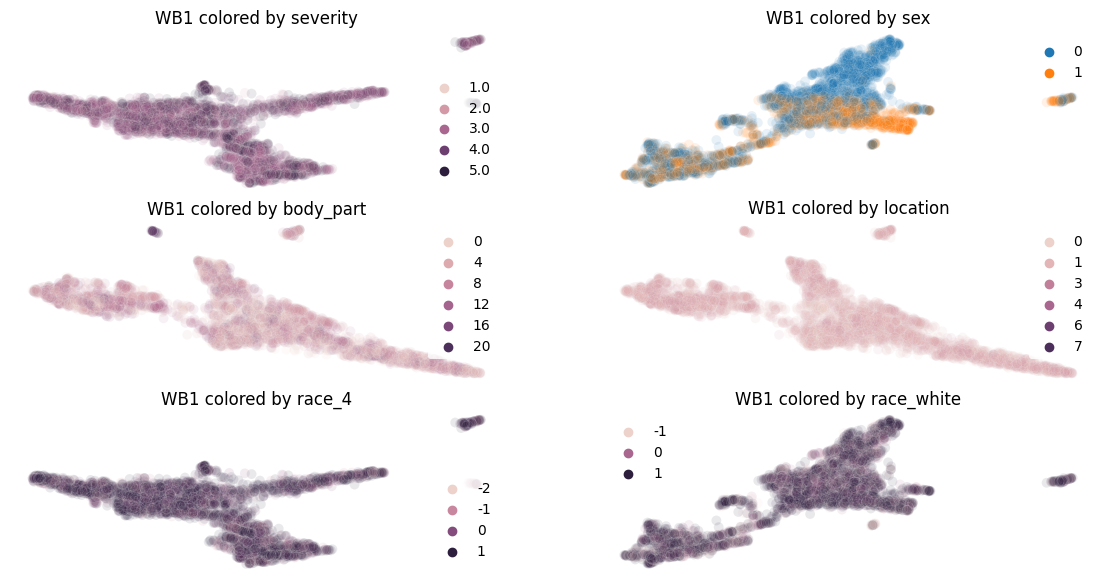

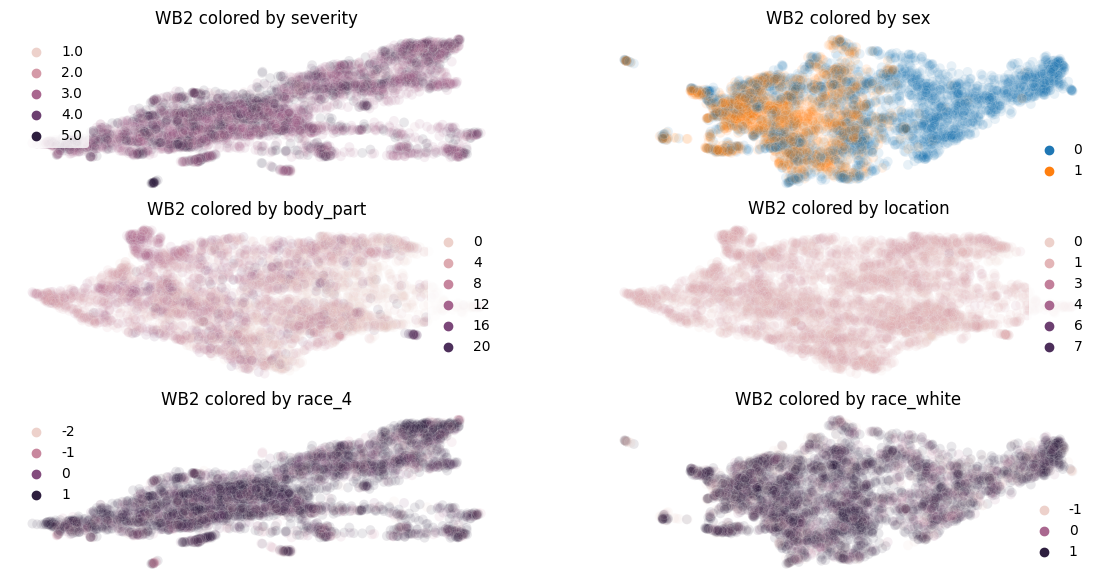

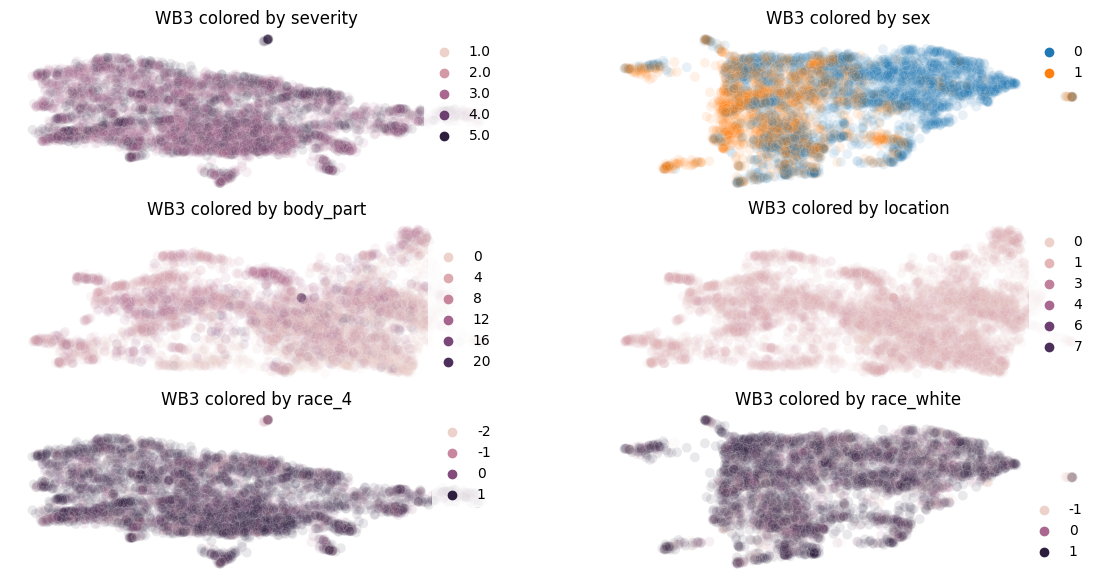

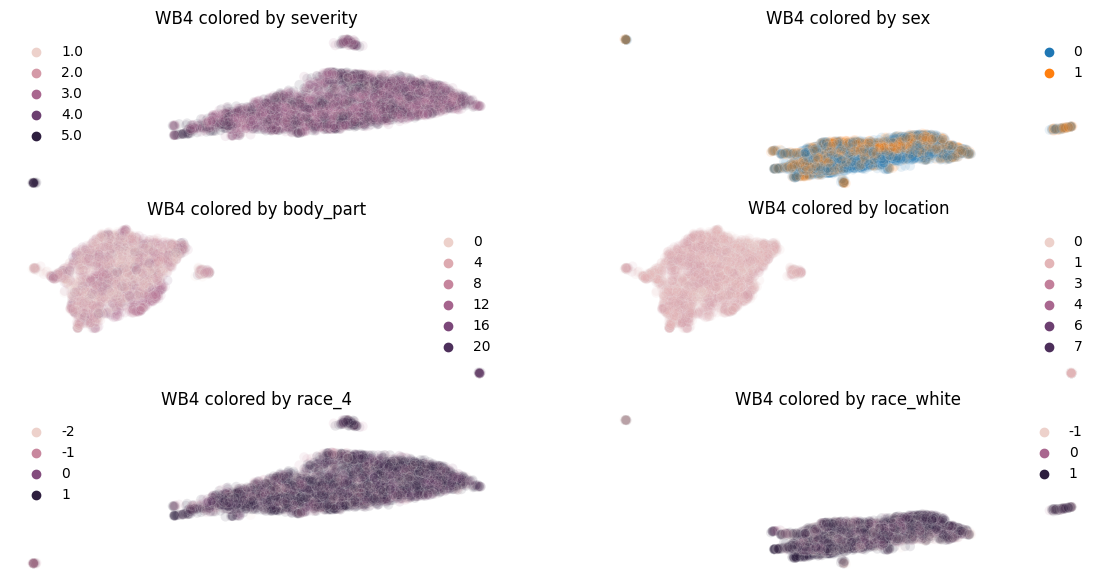

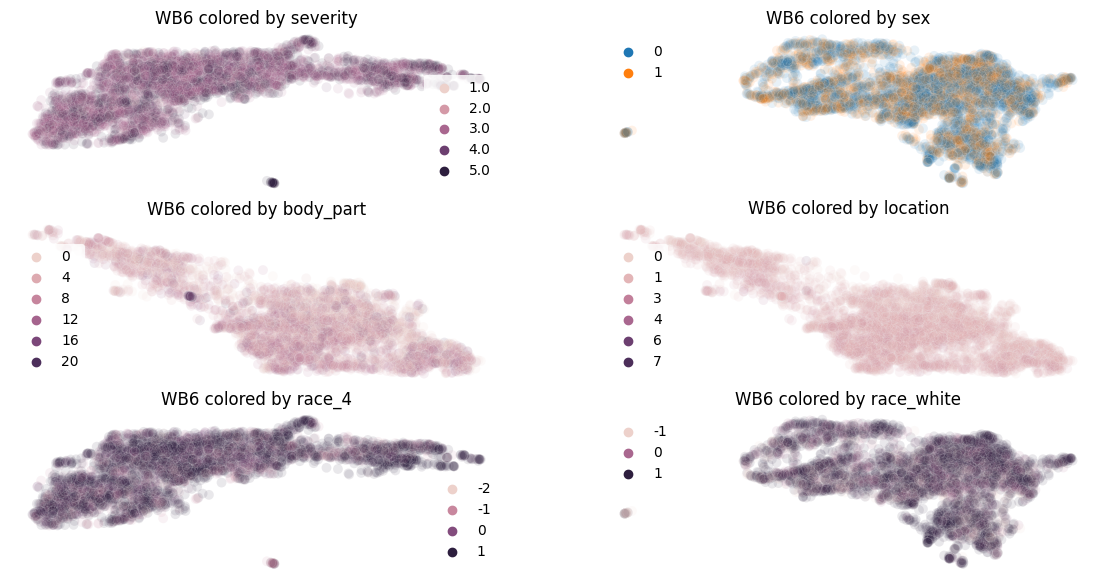

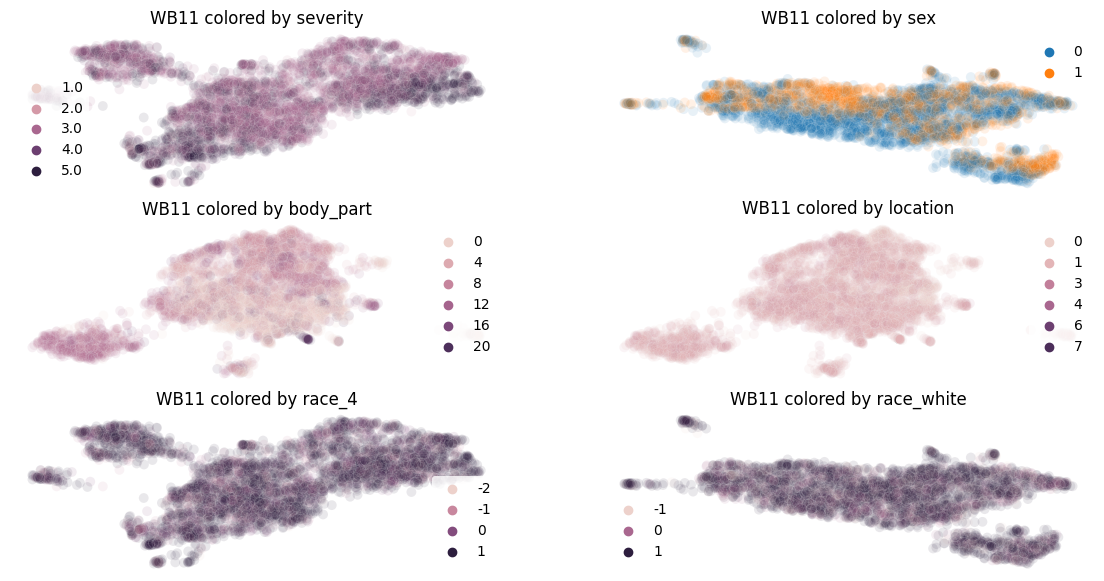

In [ ]:
%%time

# same dimensions
def show_umaps( mid, rdims ):
    t='trn'
    X_embedded = reducers[mid,rdims].transform( Embeddings[mid,t]  )
    embedded_dict = {}
    for i in range(0,X_embedded.shape[1]):
        embedded_dict[f"Dim {i+1}"] = X_embedded[:,i]

    projected = pd.DataFrame( embedded_dict )
    projected['cids']= cnums[t]

    for k in ['sex', 'age_cate_binned','body_part','location', 'diagnosis','race_white','race_4', 'severity']:
        projected[k]= surv_pols[t].to_pandas()[k]

    fname = 'DejaVu Sans'
    tfont = {'fontname':fname, 'fontsize':12} # title font attributes
    afont = {'fontname':fname, 'fontsize':10} # axis font attributes
    lfont = {'fontname':fname, 'fontsize':8}  # legend font attributes

    def tune_figure(ax, title:str='Title'):
        ax.axis('off')

        title =f'WB{mid} colored by {title}'
        ax.set_title(title, **tfont)
        ax.get_legend().set_title("")
        ax.get_legend().prop.set_family(lfont['fontname'])
        ax.get_legend().prop.set_size(lfont['fontsize'])
        ax.get_legend().get_frame().set_linewidth(0.0)

    f, axs = plt.subplots(3,2,figsize=(14,7))
    try:
        axs = axs.flatten()
    except:
        pass

    d,k=3,'location'
    sns.scatterplot(data=projected, x='Dim 1', y='Dim 2', hue=k, s=50, alpha=0.1, ax=axs[d]);
    tune_figure(axs[d], k)

    d,k=0,'severity'
    sns.scatterplot(data=projected, x='Dim 2', y='Dim 3', hue=k, s=50, alpha=0.1, ax=axs[d]);
    tune_figure(axs[d], k)

    d,k=1,'sex'
    sns.scatterplot(data=projected, x='Dim 3', y='Dim 1', hue=k, s=50, alpha=0.1, ax=axs[d]);
    tune_figure(axs[d], k)
    d,k=2,'body_part'
    sns.scatterplot(data=projected, x='Dim 1', y='Dim 2', hue=k, s=50, alpha=0.1, ax=axs[d]);
    tune_figure(axs[d], k)

    d,k=4,'race_4'
    sns.scatterplot(data=projected, x='Dim 2', y='Dim 3', hue=k, s=50, alpha=0.1, ax=axs[d]);
    tune_figure(axs[d], k)

    d,k=5,'race_white'
    sns.scatterplot(data=projected, x='Dim 3', y='Dim 1', hue=k, s=50, alpha=0.1, ax=axs[d]);
    tune_figure(axs[d], k)

# viewing different combination (including 3rd and 4th dims)
[show_umaps( s, r) for r in [4] for s in EMB]

## Transform the rest of the (test) word embeddings using the fitted UMAP

In [ ]:
try:
    word_reduced;
except:
    word_reduced={}
    for emb in [1,2,3,4,6,11]:
        T = ['trn', 'val','tst']
        if emb == 11:
            T = ['trn','val']
        if emb>0:
            for r in [4]:
                for t in T:
                    try:
                        word_reduced[emb,t];
                    except:
                        word_reduced[emb,t] = reducers[emb,r].transform( Embeddings[emb,t])

# More preliminary analysis

## Examine lengths of narratives (400-word narrative only introduced in a later time period)

In [ ]:
for t in ['trn','tst']:
    surv_pols[t]= surv_pols[t].with_columns([
        pol.col("narrative").str.lengths().alias("narrative_len")
    ])
    fig=px.histogram( surv_pols[t].to_pandas(),'narrative_len')
    fig.show()

# Develop and evaluate survival analysis models based on eXtreme Gradient Boost with hyperparameter optimization using the ```optuna``` package


- The loop below will walk through a series of trials to collect statistics that quantify illustrate the effects of input data types to each survival model candidate
- Within each trial, we use the ```optuna``` object, via ```run_xgb_optuna```  function wherein the optuna object will conduct Bayesian search with steps equal to the value of ```n_trials```

- **Warning**: this section will take some time. For a quick dry-run, change these values:
  ```n_trials= (100 if INTERACTIVE else 500)```
  




In [ ]:
pos_ratio = 1-np.isinf( surv_inter['trn']['label_upper_bound'] ).sum() / surv_inter['trn'].shape[0]
print( 'pos-neg-ratio:', pos_ratio,  )
#exec( open('n4.py','r').read() )

pos-neg-ratio: 0.33886255924170616


## Adjust ```n_trials``` hyperparamter for fine-grained (or coarse) hyperparameter search

In [ ]:
n_trials= (100 if INTERACTIVE else 500)
n_trials

100

## Define function that calls the ```optuna``` object performing hyperparameter optimization of model parameters involved in each trial

In [ ]:
import xgboost as xgb
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score, log_loss

from datetime import date

def run_xgb_optuna( T, emb, X, surv_inter ):
    ds = {}
    base_params = {'verbosity': 0,
                  'objective': 'survival:aft',
                  'eval_metric': 'aft-nloglik',
                  'tree_method': 'hist'}  # Hyperparameters common to all trials
    samp_choices = ['uniform']

    for t in T:
        ds[t] = xgb.DMatrix( X[t])
        # see details https://xgboost.readthedocs.io/en/stable/tutorials/aft_survival_analysis.html
        ds[t].set_float_info('label_lower_bound', surv_inter[t]['label_lower_bound'] )
        ds[t].set_float_info('label_upper_bound', surv_inter[t]['label_upper_bound'] )

    t='trn1'
    print(X['trn'][0::2,:].shape )
    ds[t] = xgb.DMatrix( X['trn'][0::2,:] )
    ds[t].set_float_info('label_lower_bound', surv_inter['trn']['label_lower_bound'][0::2])
    ds[t].set_float_info('label_upper_bound', surv_inter['trn']['label_upper_bound'][1::2])
    t='trn2'
    ds[t] = xgb.DMatrix( X['trn'][1::2,:] )
    ds[t].set_float_info('label_lower_bound', surv_inter['trn']['label_lower_bound'][0::2])
    ds[t].set_float_info('label_upper_bound', surv_inter['trn']['label_upper_bound'][1::2])

    if gpus:
        base_params.update( {'tree_method': 'gpu_hist', 'device':'cuda', } )
        samp_choices = ['gradient_based','uniform']

    def tuner(trial):
        params = {'learning_rate': trial.suggest_float('learning_rate', 0.001, 1.0),
                  'aft_loss_distribution': trial.suggest_categorical('aft_loss_distribution',
                                                                      ['normal', 'logistic', 'extreme']),
                  'aft_loss_distribution_scale': trial.suggest_float('aft_loss_distribution_scale', 0.1, 10.0),
                  'max_depth': trial.suggest_int('max_depth', 3, 10),
                  'booster': trial.suggest_categorical('booster',['gbtree','dart',]),
                  'scale_pos_weight': trial.suggest_float('scale_pos_weight', pos_ratio*0.1, 10*pos_ratio ),  # L1 reg on weights
                  'alpha': trial.suggest_float('alpha', 1e-8, 10 ),  # L1 reg on weights
                  'lambda': trial.suggest_float('lambda', 1e-8, 10 ),  # L2 reg on weights
                  'eta': trial.suggest_float('eta', 0, 1.0),  # step size
                  'sampling_method': trial.suggest_categorical('sampling_method', samp_choices ),
                  'subsample': trial.suggest_float('subsample', 0.01, 1 ),
                  'gamma': trial.suggest_float('gamma', 1e-8, 10)  # larger, more conservative; min loss reduction required to make leaf
        }
        params.update(base_params)
        pruning_callback = optuna.integration.XGBoostPruningCallback(trial, 'valid-aft-nloglik')
        bst = xgb.train(params, ds['trn1'], num_boost_round=10000,
                        evals=[(ds['trn1'], 'train'), (ds['trn2'], 'valid')],  # <---- data matrices
                        early_stopping_rounds=50, verbose_eval=False, callbacks=[pruning_callback])
        if bst.best_iteration >= 25:
            return bst.best_score
        else:
            return np.inf  # Reject models with < 25 trees

    # Run hyperparameter search
    study = optuna.create_study(direction='minimize')
    study.optimize( tuner, n_trials= n_trials )
    print('Completed hyperparameter tuning with best aft-nloglik = {}.'.format(study.best_trial.value))
    params = {}
    params.update(base_params)
    params.update(study.best_trial.params)

    print('Re-running the best trial... params = {}'.format(params))
    bst = xgb.train(params, ds['trn1'], num_boost_round=10000, verbose_eval=False,
                    evals=[(ds['trn1'], 'train'), (ds['trn2'], 'valid')],
                    early_stopping_rounds=50)

    # Explore hyperparameter search space
    fig = optuna.visualization.plot_param_importances(study)
    fig.show()

    for t in T:
        try:
            res[t]= pd.DataFrame({'Label (lower bound)': surv_inter[t]['label_lower_bound'],
                       'Label (upper bound)': surv_inter[t]['label_upper_bound'],
                       'Predicted label': bst.predict(ds[t]) } )

            sp=scipy.stats.spearmanr( res[t].iloc[:,-2], res[t].iloc[:,-1] )
            c=concordance_index_censored( event_time = time2event[t], event_indicator = event_indicator[t] , estimate=1/res[t].iloc[:,-1] )

            print(t.upper(), f'| R2:{sp[0]:.3f}; p:{sp[1]:.4} | C:{c[0]*100:.2f} ', end='|' )
            for d,h in enumerate([3,6,9,12,15,18,24,49,73, 7*24+1, 7*24*2+1, 7*24*4+1 ]):
                bs = brier_score( surv_str['trn'], surv_str[t], estimate=1/res[t].iloc[:,-1], times=[h] )
                print( end=f'{labels[d]}:{bs[1][0]:.3f} |' )
            print()
        except:
            pass

    today = date.today()
    bst.save_model(f'aft_model_{emb}_{today}.json')
    return res

## Loop over a series of trials to compare the effects of input data types

The for-loop below explores input types, depending on ```input_type```:
- ```input_type=1 # 2, 3, 4```: original word embedding
- ```input_type=21 # 22, 23, 24, 26 ```: dimensionality reduced versions of word embedding
- ```input_type=25```: all dimensionality reduced versions of word embedding, *plus* baseline variables


In [ ]:
# ====================================
# Begin XGB/ Optuna search
# ====================================
pos_ratio = 1-np.isinf( surv_inter['trn']['label_upper_bound'] ).sum() / surv_inter['trn'].shape[0]
print( 'pos-neg-ratio:', pos_ratio,  )

for input_type in [21,22,23,24,26]:  # part 1 : 6,19,20,
    X,res ={},{}
    if input_type==11:
        T=['trn','val']
    else:
        T=['trn','val','tst']
    for t in T:
        if input_type =19:
            X[t] = np.hstack( (Embeddings[1,t],Embeddings[2,t],Embeddings[3,t], Embeddings[4,t], Embeddings[6,t] ) )
        else: # 1-4,6,11
            try:
                X[t] = Embeddings[input_type,t].to_numpy()
            except:
                print(emb,'skip numpy')
                X[t] = Embeddings[input_type,t]
        if input_type == 20:
            X[t] = np.hstack( (X[t], surv_pols[t][att].to_pandas()) )
        elif input_type== 25:
            X[t] = np.hstack( (word_reduced[1,t],word_reduced[2,t],word_reduced[3,t],word_reduced[4,t],word_reduced[6,t], surv_pols[t][att].to_pandas()  ) )
        elif input_type >= 21: # dim reduced versions for comparison with Cox regression to be done next code block
            rr = input_type - 20
            X[t] = np.hstack( (word_reduced[rr,t], surv_pols[t][att].to_pandas() ) )

    res = run_xgb_optuna( T, input_type, X, surv_inter)

pos-neg-ratio: 0.33886255924170616


[I 2023-11-22 16:22:03,702] A new study created in memory with name: no-name-de21a333-8b3e-4ce2-8ac4-2738597bef63


(2532, 17)


[I 2023-11-22 16:22:05,687] Trial 0 finished with value: 4.652671201114625 and parameters: {'learning_rate': 0.5465165233722031, 'aft_loss_distribution': 'normal', 'aft_loss_distribution_scale': 4.763320112776727, 'max_depth': 5, 'booster': 'gbtree', 'scale_pos_weight': 2.734731825734446, 'alpha': 7.090522228321418, 'lambda': 5.788565148422231, 'eta': 0.9637374253012001, 'sampling_method': 'uniform', 'subsample': 0.25821567385954936, 'gamma': 8.830978804439392}. Best is trial 0 with value: 4.652671201114625.
[I 2023-11-22 16:22:16,041] Trial 1 finished with value: 4.798498694970963 and parameters: {'learning_rate': 0.11886337807627738, 'aft_loss_distribution': 'extreme', 'aft_loss_distribution_scale': 6.2187490883521015, 'max_depth': 8, 'booster': 'dart', 'scale_pos_weight': 1.1470660433163602, 'alpha': 3.462129389647477, 'lambda': 3.276428524785196, 'eta': 0.497877085430129, 'sampling_method': 'gradient_based', 'subsample': 0.3323336143527213, 'gamma': 0.32035771154476494}. Best is tr

Completed hyperparameter tuning with best aft-nloglik = 4.5293126952268254.
Re-running the best trial... params = {'verbosity': 0, 'objective': 'survival:aft', 'eval_metric': 'aft-nloglik', 'tree_method': 'gpu_hist', 'device': 'cuda', 'learning_rate': 0.912636244452209, 'aft_loss_distribution': 'normal', 'aft_loss_distribution_scale': 2.222429764953636, 'max_depth': 6, 'booster': 'gbtree', 'scale_pos_weight': 2.8928810718294846, 'alpha': 8.42209846657913, 'lambda': 0.2174522890111682, 'eta': 0.8664331545007653, 'sampling_method': 'uniform', 'subsample': 0.8853417425316554, 'gamma': 8.942642749205866}


[W 2023-11-22 16:25:03,164] Trial 2 is omitted in visualization because its objective value is inf or nan.
[W 2023-11-22 16:25:03,166] Trial 16 is omitted in visualization because its objective value is inf or nan.
[W 2023-11-22 16:25:03,168] Trial 35 is omitted in visualization because its objective value is inf or nan.
[W 2023-11-22 16:25:03,169] Trial 80 is omitted in visualization because its objective value is inf or nan.


/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.



TRN | R2:nan; p:nan | C:50.00 |3h:0.986 |6h:0.985 |9h:0.980 |12h:0.855 |15h:0.855 |18h:0.855 |24h:0.846 |2d:0.636 |3d:0.582 |1w:0.389 |2w:0.285 |1mo:0.220 |
VAL | R2:nan; p:nan | C:50.00 |3h:0.986 |6h:0.985 |9h:0.979 |12h:0.849 |15h:0.849 |18h:0.849 |24h:0.835 |2d:0.617 |3d:0.565 |1w:0.366 |2w:0.416 |1mo:0.330 |


/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.



TST | R2:nan; p:nan | C:50.00 |3h:0.988 |6h:0.987 |9h:0.985 |12h:0.928 |15h:0.928 |18h:0.928 |24h:0.919 |2d:0.760 |3d:0.714 |1w:0.507 |2w:0.494 |1mo:0.367 |


[I 2023-11-22 16:25:05,981] A new study created in memory with name: no-name-15cc2590-7376-4f5f-ab85-b148e4cd9027


(2532, 17)


[I 2023-11-22 16:25:08,926] Trial 0 finished with value: 4.554304630758678 and parameters: {'learning_rate': 0.45220321905872257, 'aft_loss_distribution': 'extreme', 'aft_loss_distribution_scale': 1.4640000524587078, 'max_depth': 5, 'booster': 'dart', 'scale_pos_weight': 0.5693546890573573, 'alpha': 7.60997597764856, 'lambda': 9.777605638654766, 'eta': 0.44272774738581244, 'sampling_method': 'gradient_based', 'subsample': 0.7652884251641804, 'gamma': 2.7778148802504483}. Best is trial 0 with value: 4.554304630758678.
[I 2023-11-22 16:25:09,447] Trial 1 finished with value: 4.912445783525923 and parameters: {'learning_rate': 0.2961806490140508, 'aft_loss_distribution': 'logistic', 'aft_loss_distribution_scale': 9.868049269286903, 'max_depth': 6, 'booster': 'gbtree', 'scale_pos_weight': 0.5619615798480309, 'alpha': 4.973332131483705, 'lambda': 1.3714109862734136, 'eta': 0.8748608565493039, 'sampling_method': 'gradient_based', 'subsample': 0.9579201743078993, 'gamma': 1.0801495504969183}.

Completed hyperparameter tuning with best aft-nloglik = 4.552504454093145.
Re-running the best trial... params = {'verbosity': 0, 'objective': 'survival:aft', 'eval_metric': 'aft-nloglik', 'tree_method': 'gpu_hist', 'device': 'cuda', 'learning_rate': 0.40395878576933364, 'aft_loss_distribution': 'logistic', 'aft_loss_distribution_scale': 1.44042771969813, 'max_depth': 5, 'booster': 'gbtree', 'scale_pos_weight': 0.6137514733936187, 'alpha': 7.166119304229551, 'lambda': 7.033216259243087, 'eta': 0.057412318726663636, 'sampling_method': 'uniform', 'subsample': 0.5969991863540836, 'gamma': 4.1809246552097585}


[W 2023-11-22 16:26:08,452] Trial 2 is omitted in visualization because its objective value is inf or nan.
[W 2023-11-22 16:26:08,453] Trial 17 is omitted in visualization because its objective value is inf or nan.
[W 2023-11-22 16:26:08,455] Trial 51 is omitted in visualization because its objective value is inf or nan.
[W 2023-11-22 16:26:08,457] Trial 54 is omitted in visualization because its objective value is inf or nan.
[W 2023-11-22 16:26:08,462] Trial 70 is omitted in visualization because its objective value is inf or nan.
[W 2023-11-22 16:26:08,467] Trial 73 is omitted in visualization because its objective value is inf or nan.
[W 2023-11-22 16:26:08,470] Trial 84 is omitted in visualization because its objective value is inf or nan.
[W 2023-11-22 16:26:08,474] Trial 93 is omitted in visualization because its objective value is inf or nan.


TRN | R2:0.073; p:2.391e-07 | C:56.66 |3h:0.985 |6h:0.984 |9h:0.980 |12h:0.854 |15h:0.854 |18h:0.854 |24h:0.845 |2d:0.635 |3d:0.582 |1w:0.389 |2w:0.285 |1mo:0.220 |
VAL | R2:0.058; p:4.082e-05 | C:55.62 |3h:0.986 |6h:0.984 |9h:0.978 |12h:0.849 |15h:0.848 |18h:0.848 |24h:0.834 |2d:0.617 |3d:0.565 |1w:0.366 |2w:0.416 |1mo:0.330 |
TST | R2:0.070; p:2.224e-24 | C:55.82 |3h:0.988 |6h:0.986 |9h:0.984 |12h:0.927 |15h:0.927 |18h:0.927 |24h:0.918 |2d:0.760 |3d:0.714 |1w:0.507 |2w:0.494 |1mo:0.367 |


[I 2023-11-22 16:26:11,996] A new study created in memory with name: no-name-b5893ba1-a866-4e8b-b5d5-bdff91ab043f


(2532, 17)


[I 2023-11-22 16:26:15,193] Trial 0 finished with value: 4.736367836910018 and parameters: {'learning_rate': 0.31850772380036413, 'aft_loss_distribution': 'logistic', 'aft_loss_distribution_scale': 4.173795331268689, 'max_depth': 5, 'booster': 'dart', 'scale_pos_weight': 0.35316823735099345, 'alpha': 0.8365653281982857, 'lambda': 5.819276620585552, 'eta': 0.31358669935348316, 'sampling_method': 'uniform', 'subsample': 0.5436144595530729, 'gamma': 5.058122923758075}. Best is trial 0 with value: 4.736367836910018.
[I 2023-11-22 16:26:15,702] Trial 1 finished with value: 4.7556390214265845 and parameters: {'learning_rate': 0.40521041898949256, 'aft_loss_distribution': 'logistic', 'aft_loss_distribution_scale': 4.530307046281327, 'max_depth': 9, 'booster': 'gbtree', 'scale_pos_weight': 2.8875237256954662, 'alpha': 9.750489156415734, 'lambda': 6.671401615821004, 'eta': 0.9091056541221311, 'sampling_method': 'gradient_based', 'subsample': 0.6482529931387995, 'gamma': 7.354994705749487}. Best

Completed hyperparameter tuning with best aft-nloglik = 4.521348195531907.
Re-running the best trial... params = {'verbosity': 0, 'objective': 'survival:aft', 'eval_metric': 'aft-nloglik', 'tree_method': 'gpu_hist', 'device': 'cuda', 'learning_rate': 0.026735969409016184, 'aft_loss_distribution': 'logistic', 'aft_loss_distribution_scale': 1.0364681956137944, 'max_depth': 10, 'booster': 'dart', 'scale_pos_weight': 2.6819047599925994, 'alpha': 4.872427480398178, 'lambda': 2.424248919126487, 'eta': 0.12174826569391062, 'sampling_method': 'gradient_based', 'subsample': 0.6438024364154791, 'gamma': 4.662610012818732}


[W 2023-11-22 16:29:48,550] Trial 28 is omitted in visualization because its objective value is inf or nan.
[W 2023-11-22 16:29:48,556] Trial 70 is omitted in visualization because its objective value is inf or nan.
[W 2023-11-22 16:29:48,558] Trial 80 is omitted in visualization because its objective value is inf or nan.


TRN | R2:0.010; p:0.4563 | C:54.77 |3h:0.979 |6h:0.978 |9h:0.974 |12h:0.849 |15h:0.849 |18h:0.849 |24h:0.840 |2d:0.632 |3d:0.579 |1w:0.387 |2w:0.283 |1mo:0.219 |
VAL | R2:-0.009; p:0.509 | C:53.93 |3h:0.979 |6h:0.978 |9h:0.972 |12h:0.843 |15h:0.843 |18h:0.843 |24h:0.829 |2d:0.613 |3d:0.562 |1w:0.364 |2w:0.413 |1mo:0.328 |
TST | R2:-0.014; p:0.04553 | C:53.21 |3h:0.981 |6h:0.980 |9h:0.978 |12h:0.921 |15h:0.921 |18h:0.921 |24h:0.912 |2d:0.755 |3d:0.710 |1w:0.504 |2w:0.491 |1mo:0.365 |


[I 2023-11-22 16:29:52,646] A new study created in memory with name: no-name-942c485a-95d7-420e-b54b-aba96475756b


(2532, 17)


[I 2023-11-22 16:30:39,077] Trial 0 finished with value: 4.701499326198225 and parameters: {'learning_rate': 0.23251059346351582, 'aft_loss_distribution': 'normal', 'aft_loss_distribution_scale': 6.142839289576386, 'max_depth': 5, 'booster': 'dart', 'scale_pos_weight': 1.2869194302816782, 'alpha': 9.2042499761202, 'lambda': 5.425870154008507, 'eta': 0.7827796076276701, 'sampling_method': 'uniform', 'subsample': 0.9253880711332683, 'gamma': 7.91662394026998}. Best is trial 0 with value: 4.701499326198225.
[I 2023-11-22 16:31:23,894] Trial 1 finished with value: 4.772024487882453 and parameters: {'learning_rate': 0.13594123094597804, 'aft_loss_distribution': 'extreme', 'aft_loss_distribution_scale': 5.328269275189591, 'max_depth': 6, 'booster': 'dart', 'scale_pos_weight': 0.3743949645022266, 'alpha': 8.933241623859312, 'lambda': 4.556526392406541, 'eta': 0.7074516832006467, 'sampling_method': 'uniform', 'subsample': 0.9872880500656851, 'gamma': 8.923874039280703}. Best is trial 0 with va

Completed hyperparameter tuning with best aft-nloglik = 4.49349272586787.
Re-running the best trial... params = {'verbosity': 0, 'objective': 'survival:aft', 'eval_metric': 'aft-nloglik', 'tree_method': 'gpu_hist', 'device': 'cuda', 'learning_rate': 0.8339747482883152, 'aft_loss_distribution': 'normal', 'aft_loss_distribution_scale': 1.5970139631799989, 'max_depth': 6, 'booster': 'dart', 'scale_pos_weight': 0.18818899114430998, 'alpha': 1.0867681831732663, 'lambda': 7.61802363567955, 'eta': 0.45177761161893704, 'sampling_method': 'uniform', 'subsample': 0.43073469367766276, 'gamma': 9.66461605693767}


[W 2023-11-22 16:34:44,439] Trial 2 is omitted in visualization because its objective value is inf or nan.
[W 2023-11-22 16:34:44,446] Trial 3 is omitted in visualization because its objective value is inf or nan.
[W 2023-11-22 16:34:44,448] Trial 5 is omitted in visualization because its objective value is inf or nan.
[W 2023-11-22 16:34:44,450] Trial 24 is omitted in visualization because its objective value is inf or nan.
[W 2023-11-22 16:34:44,452] Trial 26 is omitted in visualization because its objective value is inf or nan.
[W 2023-11-22 16:34:44,455] Trial 32 is omitted in visualization because its objective value is inf or nan.
[W 2023-11-22 16:34:44,457] Trial 40 is omitted in visualization because its objective value is inf or nan.
[W 2023-11-22 16:34:44,458] Trial 41 is omitted in visualization because its objective value is inf or nan.
[W 2023-11-22 16:34:44,461] Trial 46 is omitted in visualization because its objective value is inf or nan.
[W 2023-11-22 16:34:44,464] Tri

TRN | R2:0.114; p:3.367e-16 | C:59.88 |3h:0.979 |6h:0.978 |9h:0.973 |12h:0.849 |15h:0.849 |18h:0.849 |24h:0.840 |2d:0.632 |3d:0.579 |1w:0.387 |2w:0.284 |1mo:0.219 |
VAL | R2:0.089; p:2.025e-10 | C:58.32 |3h:0.979 |6h:0.977 |9h:0.971 |12h:0.843 |15h:0.843 |18h:0.843 |24h:0.829 |2d:0.614 |3d:0.562 |1w:0.364 |2w:0.414 |1mo:0.328 |
TST | R2:0.121; p:9.686e-71 | C:59.32 |3h:0.981 |6h:0.980 |9h:0.978 |12h:0.922 |15h:0.921 |18h:0.921 |24h:0.912 |2d:0.755 |3d:0.710 |1w:0.504 |2w:0.492 |1mo:0.365 |


[I 2023-11-22 16:34:48,759] A new study created in memory with name: no-name-7aff0f33-adc3-4c12-b08b-ca3fbbd0a59b


(2532, 17)


[I 2023-11-22 16:34:49,034] Trial 0 finished with value: 4.779746339814822 and parameters: {'learning_rate': 0.8384940371820692, 'aft_loss_distribution': 'normal', 'aft_loss_distribution_scale': 9.318615288070443, 'max_depth': 9, 'booster': 'gbtree', 'scale_pos_weight': 1.5697847509065297, 'alpha': 6.959298733866316, 'lambda': 5.5397719009851345, 'eta': 0.5647265227580248, 'sampling_method': 'gradient_based', 'subsample': 0.332234562864745, 'gamma': 3.3589506926438264}. Best is trial 0 with value: 4.779746339814822.
[I 2023-11-22 16:39:12,025] Trial 1 finished with value: 4.7026674900218115 and parameters: {'learning_rate': 0.029100428871087318, 'aft_loss_distribution': 'normal', 'aft_loss_distribution_scale': 6.193909089365002, 'max_depth': 9, 'booster': 'dart', 'scale_pos_weight': 1.0213662292311736, 'alpha': 3.184909638464767, 'lambda': 4.244203228180438, 'eta': 0.3001970548363675, 'sampling_method': 'uniform', 'subsample': 0.8870937340579675, 'gamma': 0.3959897412920481}. Best is t

Completed hyperparameter tuning with best aft-nloglik = 4.608913973251802.
Re-running the best trial... params = {'verbosity': 0, 'objective': 'survival:aft', 'eval_metric': 'aft-nloglik', 'tree_method': 'gpu_hist', 'device': 'cuda', 'learning_rate': 0.5899036184640338, 'aft_loss_distribution': 'normal', 'aft_loss_distribution_scale': 3.719293850377851, 'max_depth': 5, 'booster': 'dart', 'scale_pos_weight': 1.8168423286749893, 'alpha': 8.052203093159235, 'lambda': 9.4599869676966, 'eta': 0.07850209717265036, 'sampling_method': 'gradient_based', 'subsample': 0.8664340118928242, 'gamma': 5.037538653167541}


[W 2023-11-22 17:27:54,188] Trial 32 is omitted in visualization because its objective value is inf or nan.
[W 2023-11-22 17:27:54,189] Trial 54 is omitted in visualization because its objective value is inf or nan.
[W 2023-11-22 17:27:54,198] Trial 55 is omitted in visualization because its objective value is inf or nan.
[W 2023-11-22 17:27:54,199] Trial 57 is omitted in visualization because its objective value is inf or nan.
[W 2023-11-22 17:27:54,200] Trial 58 is omitted in visualization because its objective value is inf or nan.
[W 2023-11-22 17:27:54,203] Trial 73 is omitted in visualization because its objective value is inf or nan.
[W 2023-11-22 17:27:54,208] Trial 83 is omitted in visualization because its objective value is inf or nan.
[W 2023-11-22 17:27:54,209] Trial 88 is omitted in visualization because its objective value is inf or nan.


TRN | R2:0.142; p:3.762e-24 | C:70.42 |3h:0.993 |6h:0.993 |9h:0.988 |12h:0.862 |15h:0.862 |18h:0.862 |24h:0.853 |2d:0.641 |3d:0.587 |1w:0.393 |2w:0.288 |1mo:0.222 |
VAL | R2:0.155; p:1.707e-28 | C:70.32 |3h:0.994 |6h:0.992 |9h:0.986 |12h:0.856 |15h:0.856 |18h:0.856 |24h:0.842 |2d:0.623 |3d:0.570 |1w:0.369 |2w:0.419 |1mo:0.333 |
TST | R2:0.169; p:4.139e-136 | C:71.60 |3h:0.996 |6h:0.994 |9h:0.992 |12h:0.935 |15h:0.935 |18h:0.935 |24h:0.926 |2d:0.766 |3d:0.721 |1w:0.511 |2w:0.498 |1mo:0.370 |


## Interpreting results/ outputs

Example output:
```
TRN | R2:0.142; p:3.762e-24 | C:70.42 |3h:0.993 |6h:0.993 |9h:0.988 |12h:0.862 |15h:0.862 |18h:0.862 |24h:0.853 |2d:0.641 |3d:0.587 |1w:0.393 |2w:0.288 |1mo:0.222 |
VAL | R2:0.155; p:1.707e-28 | C:70.32 |3h:0.994 |6h:0.992 |9h:0.986 |12h:0.856 |15h:0.856 |18h:0.856 |24h:0.842 |2d:0.623 |3d:0.570 |1w:0.369 |2w:0.419 |1mo:0.333 |
TST | R2:0.169; p:4.139e-136 | C:71.60 |3h:0.996 |6h:0.994 |9h:0.992 |12h:0.935 |15h:0.935 |18h:0.935 |24h:0.926 |2d:0.766 |3d:0.721 |1w:0.511 |2w:0.498 |1mo:0.370 |
```



- Overall concordant indices for the ```TRN```, ```VAL```, and evaluation subsets (```TST```) are 0.704, 0.703, 0.716, respectively.

- Concordant indices for predicting risk of experience the outcome within 12 hours' time: 0.862, 0.856, 0.935  


# Cox regression analysis for baseline comparison and preliminary interpretations


Attribute subsets
att1: ['location', 'product_1', 'product_2', 'product_3', 'body_part', 'drug', 'alcohol', 'sex', 'age_cate_binned', 'year', 'month', 'time2hosp', 'severity'] 
att2: ['location', 'product_1', 'product_2', 'product_3', 'body_part', 'drug', 'alcohol', 'sex', 'age_cate_binned', 'race_recoded', 'year', 'month', 'time2hosp', 'severity']
---------------------------------------------------------------------------------------------------- -1 


InputSet-1
 TRN | R2:0.184; p:1.201e-39 | C:58.23 
3h:0.997 | 6h:0.996 | 9h:0.990 | 12h:0.858 | 15h:0.855 | 18h:0.853 | 24h:0.844 | 2d:0.634 | 3d:0.580 | 1w:0.387 | 	0.576
InputSet-1
 VAL | R2:0.156; p:5.188e-29 | C:57.99 
3h:0.998 | 6h:0.995 | 9h:0.989 | 12h:0.852 | 15h:0.849 | 18h:0.847 | 24h:0.833 | 2d:0.616 | 3d:0.563 | 1w:0.364 | 	0.564
InputSet-1
 TST | R2:0.148; p:1.226e-104 | C:55.31 
3h:1.000 | 6h:0.998 | 9h:0.995 | 12h:0.931 | 15h:0.928 | 18h:0.926 | 24h:0.917 | 2d:0.758 | 3d:0.711 | 1w:0.504 | 	0.559





<lifelines.CoxPHFitter: fitted with 5064 total observations, 0 right-censored observations>
             duration col = 'time2hosp'
                event col = 'severity'
                penalizer = [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
                 l1 ratio = 0.1
      baseline estimation = breslow
   number of observations = 5064
number of events observed = 5064
   partial log-likelihood = -38076.02
         time fit was run = 2023-11-22 17:27:58 UTC

---
                  coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                               
location         -0.16       0.86       0.02            -0.20            -0.11                 0.82                 0.89
product_1        -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
product_2        -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
product_3        -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
body_part        -0.01       0.99       0.00            -0.02            -0.01                 0.98                 0.99
drug             -0.02       0.98       0.06            -0.13             0.10                 0.88                 1.10
alcohol           0.28       1.32       0.09             0.10             0.46                 1.11                 1.58
sex              -0.00       1.00       0.03            -0.05             0.05                 0.95                 1.06
age_cate_binned   0.07       1.08       0.02             0.05             0.10                 1.05                 1.11
race_recoded     -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
year             -0.00       1.00       0.01            -0.03             0.02                 0.97                 1.02
month             0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00

                  cmp to     z      p   -log2(p)
covariate                                       
location            0.00 -6.89 <0.005      37.34
product_1           0.00 -0.01   0.99       0.01
product_2           0.00 -0.38   0.70       0.51
product_3           0.00 -0.08   0.94       0.10
body_part           0.00 -5.03 <0.005      20.99
drug                0.00 -0.27   0.79       0.34
alcohol             0.00  3.05 <0.005       8.77
sex                 0.00 -0.01   0.99       0.01
age_cate_binned     0.00  4.95 <0.005      20.40
race_recoded        0.00 -0.00   1.00       0.01
year                0.00 -0.28   0.78       0.37
month               0.00  0.00   1.00       0.01
---
Concordance = 0.58
Partial AIC = 76176.03
log-likelihood ratio test = 121.29 on 12 df
-log2(p) of ll-ratio test = 64.66

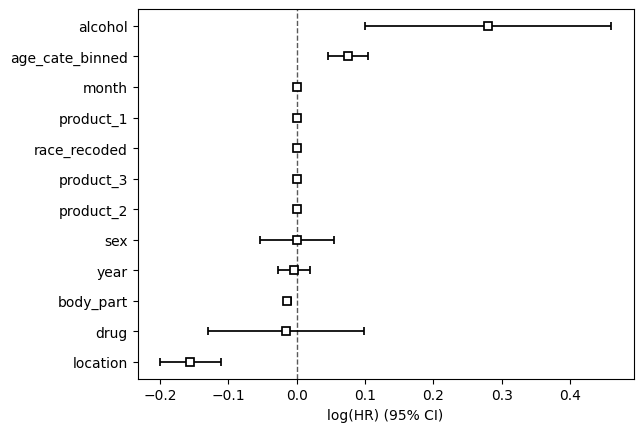

<Figure size 640x480 with 0 Axes>

In [ ]:
%matplotlib inline
from lifelines import AalenAdditiveFitter, CoxPHFitter
att =['location','product_1','product_2','product_3','fire_involvement','body_part','drug','alcohol', 'sex', 'age_cate_binned','race_recoded','year','month']

att1=att.copy() # without race
att1+=['time2hosp', 'severity']
att1.remove('fire_involvement')
att1.remove('race_recoded')

att2=att.copy()  # with race
att2+=['time2hosp', 'severity']
att2.remove('fire_involvement')
print( 'Attribute subsets\natt1:',att1, '\natt2:', att2 )

import sksurv
import matplotlib.pyplot as plt
from sksurv.util import Surv
from lifelines import CoxPHFitter
from IPython.core.display import HTML
from IPython.display import display

from lifelines.utils import k_fold_cross_validation

def run_cox():
    cphs={}
    for emb in [-1,0,1,2,3,4,6,11]:
        T = ['trn', 'val','tst']
        if emb == 11:
            T = ['trn','val']

        TIMES = [3,6,9,12,15,18,24,49,73, 7*24+1, 7*24*2+1, 7*24*4+1 ]
        trn_event_times = np.array(surv_pols['trn']['time2hosp'].unique())

        M = len(trn_event_times)

        a=np.broadcast_to( trn_event_times[:, np.newaxis], (M, len(TIMES)) )
        b=np.broadcast_to( TIMES, (M, len(TIMES) ) )
        Q=np.unique( np.argmin( (a - b)**2 ,axis=1))

        print('-'*100, emb, '\n\n')
        for t in T:
            if emb==-1:
                A = att2
            else:
                A = att1
            XX =surv_pols[t].to_pandas()[A] *1.

            if emb>0:
                XX = pd.DataFrame( np.hstack( (XX, word_reduced[emb,t]) ), columns=A +['w1','w2','w3', 'w4'] )

            if t == 'trn':
                penalty = np.ones( XX.shape[1]-2 )*.1

                aaf_1 = AalenAdditiveFitter(coef_penalizer=0.5)
                aaf_2 = AalenAdditiveFitter(coef_penalizer=10)
                cph = CoxPHFitter(penalizer=penalty, l1_ratio=.1)

                if 0:
                    print(np.mean(k_fold_cross_validation(cph, XX, duration_col='time2hosp', event_col='severity',)))# scoring_method="concordance_index")))
                    print(np.mean(k_fold_cross_validation(aaf_1, XX, duration_col='time2hosp', event_col='severity',)))# scoring_method="concordance_index")))
                    print(np.mean(k_fold_cross_validation(aaf_2, XX, duration_col='time2hosp', event_col='severity',)))# scoring_method="concordance_index")))

                cphs[emb] = CoxPHFitter(penalizer=penalty, l1_ratio=.1)
                cphs[emb].fit(XX, 'time2hosp', 'severity')

            preds = cphs[emb].predict_cumulative_hazard( XX ).iloc[Q,:]
            c=concordance_index_censored(event_time = time2event[t],
                                         event_indicator = event_indicator[t],
                                         estimate=preds.iloc[-1,:] )

            sp=scipy.stats.spearmanr( np.array( XX['time2hosp']), 1/ preds.iloc[-1,:].values  )

            print(f'InputSet{emb}\n', t.upper(), f'| R2:{sp[0]:.3f}; p:{sp[1]:.4} | C:{c[0]*100:.2f} ', )

            for d,(ii,h) in enumerate(zip(Q,TIMES)):
                try:
                    bs = brier_score( surv_str['trn'], surv_str[t], estimate= preds.iloc[ii,:], times=[h] )
                    print( end=f'{labels[d]}:{bs[1][0]:.3f} | ' )
                except:
                    pass
            c=cphs[emb].score( XX,'concordance_index')
            print( f'\t{c:.3f}' )
        print('\n\n')
        cphs[emb].print_summary()
        cphs[emb].plot()
        plt.figure()
        return cphs

cphs = run_cox()

## Interpreting the result outputs


Example output:
```
InputSet-1
 TRN | R2:0.184; p:1.201e-39 | C:58.23
3h:0.997 | 6h:0.996 | 9h:0.990 | 12h:0.858 | 15h:0.855 | 18h:0.853 | 24h:0.844 | 2d:0.634 | 3d:0.580 | 1w:0.387 | 	0.576
InputSet-1
 VAL | R2:0.156; p:5.188e-29 | C:57.99
3h:0.998 | 6h:0.995 | 9h:0.989 | 12h:0.852 | 15h:0.849 | 18h:0.847 | 24h:0.833 | 2d:0.616 | 3d:0.563 | 1w:0.364 | 	0.564
InputSet-1
 TST | R2:0.148; p:1.226e-104 | C:55.31
3h:1.000 | 6h:0.998 | 9h:0.995 | 12h:0.931 | 15h:0.928 | 18h:0.926 | 24h:0.917 | 2d:0.758 | 3d:0.711 | 1w:0.504 | 	0.559
```

- Overall concordant indices for the development set (```TRN``` and ```VAL```) and evaluation set (```TST```) are 0.582, 0.580, 0.553, respectively.

- Concordant indices for predicting risk of experience the outcome within 12 hours' time: 0.858, 0. 0.852, 0.931  


In [ ]:
!pip freeze > requirements.txt

# Analyses of results

In [ ]:
if 0:
    for t in ['trn','val', ]:
        for n in race_recoded:
            2#surv_pols[t].iloc[ n, : ]

# [Optional] Clean up static resources to save persistent storage quota (on Kaggle)

In [ ]:
if 0: # Optional
  !rm *.h5 *xlsx *gzip